## Imports

In [1063]:
import tensorflow as tf
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import quandl
import datetime
from datetime import timedelta
from datetime import datetime
from dateutil.parser import parse
import pandas as pd
import numpy as np
import xgboost as xgb
from xgboost.sklearn import XGBClassifier
from sklearn import cross_validation, metrics 
from sklearn.metrics import accuracy_score
from sklearn.grid_search import GridSearchCV
from sklearn.model_selection import GridSearchCV
import talib
from sklearn.preprocessing import StandardScaler
from keras.models import Sequential 
from keras.layers import Dense
from keras.layers import Dropout
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC
from sklearn import svm, linear_model
from sklearn.model_selection import cross_val_score
from treeinterpreter import treeinterpreter as ti
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import RandomForestClassifier
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import classification_report, confusion_matrix
rf = RandomForestRegressor()

plt.style.use('fivethirtyeight')

%matplotlib inline
%config InlineBackend.figure_format = 'retina'

np.set_printoptions(threshold=np.nan)
pd.set_option('max_columns', None)
pd.set_option('max_rows', None)

## EDA and Cleaning

Using yahoo finance I pulled th historical stock pricing data going back to 2002 

##### Loop that pulls in the stock CSV's creates proper column names

In [21]:
stock_csv_etf = ['ADS_.csv', 'BRBY_.csv', 'CDI_.csv', 'HM_B_.csv',
                 'ITX_.csv', 'JWN_.csv', 'KER_.csv', 'MC_.csv', 
                 'NKE_.csv', 'PUM_.csv', 'PVH_.csv', 'RL_.csv', 'TPR_.csv']

for csv in stock_csv_etf:
    #load in the csv
    temp = pd.read_csv("/Users/samconnelly/Desktop/Notebooks_GA/Projects/General-Assembly-Projects/CapStone/capstone_etf/"+csv)
    #create stock slug using split
    stock_slug = csv.split("_.")[0]
    temp_columns = []
    for i in temp.columns:
        temp_columns.append(i+"_"+stock_slug)
    temp.columns = temp_columns
    temp.to_csv(csv, index=False)

##### Loop that pulls in the csv's from above, sets the index to a datetime object and appends them into one dataframe

In [155]:
stock_df_etf = []
for df in stock_csv_etf:
    temp_df = pd.read_csv("/Users/samconnelly/Desktop/Notebooks_GA/Projects/General-Assembly-Projects/CapStone/"+df)
    temp_df[temp_df.columns[0]] = pd.to_datetime(temp_df[temp_df.columns[0]])
    temp_df = temp_df.set_index(temp_df.columns[0])
    stock_df_etf.append(temp_df)
    
all_etf = pd.concat(stock_df_etf, axis=1)


In [223]:
all_etf.shape

(4144, 13)

In [131]:
all_etf.T.isnull().sum()

2002-07-12     0
2002-07-15     0
2002-07-16     0
2002-07-17     0
2002-07-18     0
2002-07-19     0
2002-07-22     0
2002-07-23     0
2002-07-24     0
2002-07-25     0
2002-07-26     0
2002-07-29     0
2002-07-30     0
2002-07-31     0
2002-08-01     0
2002-08-02     0
2002-08-05     0
2002-08-06     0
2002-08-07     0
2002-08-08     0
2002-08-09     0
2002-08-12     0
2002-08-13     0
2002-08-14     0
2002-08-15     0
2002-08-16     0
2002-08-19     0
2002-08-20     0
2002-08-21     0
2002-08-22     0
2002-08-23     0
2002-08-26     0
2002-08-27     0
2002-08-28     0
2002-08-29     0
2002-08-30     0
2002-09-02     5
2002-09-03     0
2002-09-04     0
2002-09-05     0
2002-09-06     0
2002-09-09     0
2002-09-10     0
2002-09-11     0
2002-09-12     0
2002-09-13     0
2002-09-16     0
2002-09-17     0
2002-09-18     0
2002-09-19     0
2002-09-20     0
2002-09-23     0
2002-09-24     0
2002-09-25     0
2002-09-26     0
2002-09-27     0
2002-09-30     0
2002-10-01     0
2002-10-02    

##### Dropping unecessary columns from dataframe, as I was solely interested in the closing price.

In [157]:
for col in all_etf:
    if 'Adj' in col:
        all_etf.drop(col, axis=1, inplace=True)
    if 'Volume' in col:
        all_etf.drop(col, axis=1, inplace=True)
    if 'Open' in col:
        all_etf.drop(col, axis=1, inplace=True)
    if 'High' in col:
        all_etf.drop(col, axis=1, inplace=True)
    if 'Low' in col:
        all_etf.drop(col, axis=1, inplace=True)

In [179]:
all_etf.shape

(4144, 13)

##### After seeing the large amont of nan values, I had to do some background research on stock data. Quickly realizing that majority of the NaN's were due to bank holidays. Seeing that I had US and European stocks, and each european country having their own bank holidays I created a csv file of bank holidays. Given the fact that 5 of the stocks were US I decided to drop a row if a certain day had 5 or more NAN's.

In [164]:
all_etft = all_etf.T.isnull().sum()>=5

In [185]:
all_etf.T
all_etft.head()

2002-07-12    False
2002-07-15    False
2002-07-16    False
2002-07-17    False
2002-07-18    False
dtype: bool

In [188]:
zipped_values = zip(all_etf.T.isnull().sum().index, all_etf.T.isnull().sum().values)

In [189]:
cols_to_drop = []
for i,j in zipped_values:
    if j>=5:
        cols_to_drop.append(i)

In [199]:
cols_to_drop

[Timestamp('2002-09-02 00:00:00'),
 Timestamp('2002-11-28 00:00:00'),
 Timestamp('2002-12-25 00:00:00'),
 Timestamp('2003-01-01 00:00:00'),
 Timestamp('2003-01-20 00:00:00'),
 Timestamp('2003-02-17 00:00:00'),
 Timestamp('2003-04-18 00:00:00'),
 Timestamp('2003-05-26 00:00:00'),
 Timestamp('2003-07-04 00:00:00'),
 Timestamp('2003-09-01 00:00:00'),
 Timestamp('2003-11-27 00:00:00'),
 Timestamp('2003-12-25 00:00:00'),
 Timestamp('2004-01-01 00:00:00'),
 Timestamp('2004-01-19 00:00:00'),
 Timestamp('2004-02-16 00:00:00'),
 Timestamp('2004-04-09 00:00:00'),
 Timestamp('2004-05-31 00:00:00'),
 Timestamp('2004-06-11 00:00:00'),
 Timestamp('2004-07-05 00:00:00'),
 Timestamp('2004-09-06 00:00:00'),
 Timestamp('2004-11-25 00:00:00'),
 Timestamp('2004-12-24 00:00:00'),
 Timestamp('2005-01-17 00:00:00'),
 Timestamp('2005-02-21 00:00:00'),
 Timestamp('2005-03-25 00:00:00'),
 Timestamp('2005-05-30 00:00:00'),
 Timestamp('2005-07-04 00:00:00'),
 Timestamp('2005-09-05 00:00:00'),
 Timestamp('2005-11-

In [195]:
all_etf.T.head(10)

2002-07-12  2002-07-15  2002-07-16  2002-07-17  2002-07-18  \
Close_ADS    19.375000   18.665001   18.827499   19.552500   19.805000   
Close_BRBY  225.000000  225.000000  226.000000  229.000000  230.000000   
Close_CDI    32.799999   31.299999   32.000000   34.000000   36.200001   
Close_HM_B   87.750000   85.500000   87.250000   88.000000   89.000000   
Close_ITX     4.100000    3.918000    3.964000    4.076000    4.220000   
Close_JWN     9.890000    9.510000    9.410000    9.345000    9.395000   
Close_KER    82.255798   73.472504   74.030197   77.562103   84.579399   
Close_MC     42.090000   39.810001   41.250000   43.400002   46.320000   
Close_NKE     6.647500    6.550000    6.755000    6.687500    6.382500   
Close_PUM    61.360001   59.180000   56.610001   54.000000   57.529999   

            2002-07-19  2002-07-22  2002-07-23  2002-07-24  2002-07-25  \
Close_ADS    19.927500   18.512501   18.375000   18.305000   17.750000   
Close_BRBY  231.000000  224.000000  224.000000  217.500000  200.000000   
Close_CDI    34.299999   33.000000   31.700001   32.400002   32.900002   
Close_HM_B   86.000000   81.500000   78.500000   74.750000   80.250000   
Close_ITX     4.100000    3.902000    3.840000    3.722000    3.764000   
Close_JWN     8.975000    8.655000    8.800000    9.450000    9.150000   
Close_KER    81.326302   81.233398   76.818604   74.355499   76.958000   
Close_MC     44.950001   42.320000   40.959999   41.599998   42.740002   
Close_NKE     6.122500    5.942500    5.793750    6.050000    6.073750   
Close_PUM    55.320000   50.500000   48.220001   51.009998   56.750000   

            2002-07-26  2002-07-29  2002-07-30  2002-07-31  2002-08-01  \
Close_ADS    18.872499   20.142500   19.987499   19.500000   20.000000   
Close_BRBY  195.000000  199.000000  198.750000  208.000000  194.000000   
Close_CDI    32.599998   35.400002   34.799999   36.599998   33.099998   
Close_HM_B   75.750000   83.750000   84.250000   87.250000   86.750000   
Close_ITX     3.696000    4.030000    3.842000    4.000000    3.900000   
Close_JWN     9.205000    9.925000    9.790000    9.450000    8.995000   
Close_KER    79.606903   85.508904   83.742897   82.720497   77.840897   
Close_MC     42.500000   45.759998   45.150002   45.099998   42.349998   
Close_NKE     6.088750    6.356250    6.287500    6.161250    5.875000   
Close_PUM    57.500000   59.500000   56.540001   53.950001   53.700001   

            2002-08-02  2002-08-05  2002-08-06  2002-08-07  2002-08-08  \
Close_ADS    19.094999   17.549999   18.350000   19.049999   19.375000   
Close_BRBY  174.000000  160.000000  150.000000  166.000000  177.000000   
Close_CDI    33.299999   31.299999   32.200001   32.599998   32.900002   
Close_HM_B   85.000000   80.500000   81.500000   82.500000   82.000000   
Close_ITX     3.720000    3.528000    3.800000    3.900000    3.980000   
Close_JWN     8.530000    8.360000    8.870000    8.655000    8.710000   
Close_KER    75.889099   71.241898   72.914902   74.262604   75.145599   
Close_MC     42.439999   39.549999   41.549999   42.230000   42.000000   
Close_NKE     5.685000    5.488750    5.575000    5.570000    5.623750   
Close_PUM    54.500000   54.990002   57.020000   55.180000   56.939999   

            2002-08-09  2002-08-12  2002-08-13  2002-08-14  2002-08-15  \
Close_ADS    19.150000   19.125000   19.344999   19.200001   19.205000   
Close_BRBY  176.000000  173.000000  170.000000  170.000000  185.000000   
Close_CDI    33.700001   32.900002   33.200001   31.700001   33.500000   
Close_HM_B   80.000000   80.750000   80.500000   81.500000   85.000000   
Close_ITX     3.680000    3.580000    3.610000    3.708000    3.708000   
Close_JWN     8.780000    8.690000    8.615000    9.220000   10.310000   
Close_KER    75.749702   74.030197   73.333099   69.243599   72.078400   
Close_MC     43.509998   42.230000   42.730000   41.330002   43.150002   
Close_NKE     5.490000    5.346250    5.375000    5.531250    5.662500   
Close_PUM   

In [200]:
type(cols_to_drop)

list

In [204]:
all_etf_trans = all_etf.T

In [206]:
type(all_etf_trans)

pandas.core.frame.DataFrame

In [209]:
for i in all_etf_trans.columns:
    for j in cols_to_drop:
        if str(j) in str(i): 
            all_etf_trans.drop(i, axis=1, inplace=True)

In [210]:
all_etf_trans.head()

2002-07-12  2002-07-15  2002-07-16  2002-07-17  2002-07-18  \
Close_ADS    19.375000   18.665001   18.827499     19.5525   19.805000   
Close_BRBY  225.000000  225.000000  226.000000    229.0000  230.000000   
Close_CDI    32.799999   31.299999   32.000000     34.0000   36.200001   
Close_HM_B   87.750000   85.500000   87.250000     88.0000   89.000000   
Close_ITX     4.100000    3.918000    3.964000      4.0760    4.220000   

            2002-07-19  2002-07-22  2002-07-23  2002-07-24  2002-07-25  \
Close_ADS    19.927500   18.512501   18.375000   18.305000   17.750000   
Close_BRBY  231.000000  224.000000  224.000000  217.500000  200.000000   
Close_CDI    34.299999   33.000000   31.700001   32.400002   32.900002   
Close_HM_B   86.000000   81.500000   78.500000   74.750000   80.250000   
Close_ITX     4.100000    3.902000    3.840000    3.722000    3.764000   

            2002-07-26  2002-07-29  2002-07-30  2002-07-31  2002-08-01  \
Close_ADS    18.872499   20.142500   19.987499   19.500000   20.000000   
Close_BRBY  195.000000  199.000000  198.750000  208.000000  194.000000   
Close_CDI    32.599998   35.400002   34.799999   36.599998   33.099998   
Close_HM_B   75.750000   83.750000   84.250000   87.250000   86.750000   
Close_ITX     3.696000    4.030000    3.842000    4.000000    3.900000   

            2002-08-02  2002-08-05  2002-08-06  2002-08-07  2002-08-08  \
Close_ADS    19.094999   17.549999   18.350000   19.049999   19.375000   
Close_BRBY  174.000000  160.000000  150.000000  166.000000  177.000000   
Close_CDI    33.299999   31.299999   32.200001   32.599998   32.900002   
Close_HM_B   85.000000   80.500000   81.500000   82.500000   82.000000   
Close_ITX     3.720000    3.528000    3.800000    3.900000    3.980000   

            2002-08-09  2002-08-12  2002-08-13  2002-08-14  2002-08-15  \
Close_ADS    19.150000   19.125000   19.344999   19.200001      19.205   
Close_BRBY  176.000000  173.000000  170.000000  170.000000     185.000   
Close_CDI    33.700001   32.900002   33.200001   31.700001      33.500   
Close_HM_B   80.000000   80.750000   80.500000   81.500000      85.000   
Close_ITX     3.680000    3.580000    3.610000    3.708000       3.708   

            2002-08-16  2002-08-19  2002-08-20  2002-08-21  2002-08-22  \
Close_ADS    18.799999   19.150000   19.212500   19.375000      20.000   
Close_BRBY  184.000000  185.000000  185.000000  192.000000     201.000   
Close_CDI    33.799999   34.099998   33.200001   34.200001      36.000   
Close_HM_B   86.250000   86.500000   86.500000   88.750000      90.000   
Close_ITX     3.900000    3.814000    3.800000    3.980000       4.142   

            2002-08-23  2002-08-26  2002-08-27  2002-08-28  2002-08-29  \
Close_ADS    20.057501   20.057501   20.057501   20.057501      18.750   
Close_BRBY  210.000000  210.000000  216.000000  222.500000     222.000   
Close_CDI    34.799999   34.599998   35.000000   33.700001      33.000   
Close_HM_B   88.000000   85.500000   85.000000   83.500000      85.750   
Close_ITX     3.930000    3.842000    3.818000    3.800000       3.772   

            2002-08-30  2002-09-03  2002-09-04  2002-09-05  2002-09-06  \
Close_ADS    18.187500      17.975     18.2125   17.737499   18.139999   
Close_BRBY  207.000000     196.000    201.2500  197.000000  205.000000   
Close_CDI    33.099998      31.600     31.6000   30.700001   31.200001   
Close_HM_B   86.250000      84.500     83.0000   82.750000   85.250000   
Close_ITX     3.980000       3.860      3.8020    3.768000    3.730000   

            2002-09-09  2002-09-10  2002-09-11  2002-09-12  2002-09-13  \
Close_ADS    18.000000   18.580000   18.594999     18.3025   18.100000   
Close_BRBY  200.250000  203.000000  206.000000    219.2500  218.000000   
Close_CDI    31.299999   32.900002   34.099998     34.0000   32.799999   
Close_HM_B   87.000000   87.250000   88.750000     88.2500   89.750000   
Close_ITX     3.800000    3.976000    3.970000      3.8320    3.878000   

       

In [213]:
closeprice_etf = all_etf_trans.T

In [214]:
closeprice_etf.head(20)

Close_ADS  Close_BRBY  Close_CDI  Close_HM_B  Close_ITX  \
2002-07-12  19.375000      225.00  32.799999       87.75      4.100   
2002-07-15  18.665001      225.00  31.299999       85.50      3.918   
2002-07-16  18.827499      226.00  32.000000       87.25      3.964   
2002-07-17  19.552500      229.00  34.000000       88.00      4.076   
2002-07-18  19.805000      230.00  36.200001       89.00      4.220   
2002-07-19  19.927500      231.00  34.299999       86.00      4.100   
2002-07-22  18.512501      224.00  33.000000       81.50      3.902   
2002-07-23  18.375000      224.00  31.700001       78.50      3.840   
2002-07-24  18.305000      217.50  32.400002       74.75      3.722   
2002-07-25  17.750000      200.00  32.900002       80.25      3.764   
2002-07-26  18.872499      195.00  32.599998       75.75      3.696   
2002-07-29  20.142500      199.00  35.400002       83.75      4.030   
2002-07-30  19.987499      198.75  34.799999       84.25      3.842   
2002-07-31  19.500000      208.00  36.599998       87.25      4.000   
2002-08-01  20.000000      194.00  33.099998       86.75      3.900   
2002-08-02  19.094999      174.00  33.299999       85.00      3.720   
2002-08-05  17.549999      160.00  31.299999       80.50      3.528   
2002-08-06  18.350000      150.00  32.200001       81.50      3.800   
2002-08-07  19.049999      166.00  32.599998       82.50      3.900   
2002-08-08  19.375000      177.00  32.900002       82.00      3.980   

            Close_JWN  Close_KER   Close_MC  Close_NKE  Close_PUM  Close_PVH  \
2002-07-12      9.890  82.255798  42.090000    6.64750  61.360001      13.28   
2002-07-15      9.510  73.472504  39.810001    6.55000  59.180000      12.55   
2002-07-16      9.410  74.030197  41.250000    6.75500  56.610001      12.58   
2002-07-17      9.345  77.562103  43.400002    6.68750  54.000000      13.00   
2002-07-18      9.395  84.579399  46.320000    6.38250  57.529999      12.25   
2002-07-19      8.975  81.326302  44.950001    6.12250  55.320000      12.65   
2002-07-22      8.655  81.233398  42.320000    5.94250  50.500000      12.00   
2002-07-23      8.800  76.818604  40.959999    5.79375  48.220001      11.50   
2002-07-24      9.450  74.355499  41.599998    6.05000  51.009998      11.78   
2002-07-25      9.150  76.958000  42.740002    6.07375  56.750000      11.88   
2002-07-26      9.205  79.606903  42.500000    6.08875  57.500000      12.10   
2002-07-29      9.925  85.508904  45.759998    6.35625  59.500000      13.26   
2002-07-30      9.790  83.742897  45.150002    6.28750  56.540001      12.70   
2002-07-31      9.450  82.720497  45.099998    6.16125  53.950001      11.80   
2002-08-01      8.995  77.840897  42.349998    5.87500  53.700001      12.18   
2002-08-02      8.530  75.889099  42.439999    5.68500  54.500000      11.75   
2002-08-05      8.360  71.241898  39.549999    5.48875  54.990002      11.50   
2002-08-06      8.870  72.914902  41.549999    5.57500  57.020000      11.98   
2002-08-07      8.655  74.262604  42.230000    5.57000  55.180000      11.75   
2002-08-08      8.710  75.145599  42.000000    5.62375  56.939999      11.82   

             Close_RL  Close_TPR  
2002-07-12  19.980000     5.6750  
2002-07-15  20.200001     5.4375  
2002-07-16  19.770000     5.2500  
2002-07-17  19.950001     5.1750  
2002-07-18  19.600000     5.0950  
2002-07-19  19.100000     4.8800  
2002-07-22  18.350000     4.8050  
2002-07-23  18.299999     4.5325  
2002-07-24  18.760000     5.2525  
2002-07-25  19.570000     5.2025  
2002-07-26  19.900000     5.4750  
2002-07-29  20.900000     6.1800  
2002-07-30  21.040001     5.8800  
2002-07-31  20.059999     5.7000  
2002-08-01  20.260000     5.5800  
2002-08-02  20.059999     5.5800  
2002-08-05  18.680000     5.4250  
2002-08-06  19.900000     5.8750  
2002-08-07  21.059999     5.8000  
2002-08-08  21.600000     5.8675

##### There were then a few extra NAN values so I used the padding method and filled theremaining NaN's with the previous days price.

In [244]:
closeprice_etf.fillna(method='pad', inplace=True)

In [245]:
closeprice_etf.isnull().sum()

Close_ADS     0
Close_BRBY    0
Close_CDI     0
Close_HM_B    0
Close_ITX     0
Close_JWN     0
Close_KER     0
Close_MC      0
Close_NKE     0
Close_PUM     0
Close_PVH     0
Close_RL      0
Close_TPR     0
dtype: int64

In [247]:
closeprice_etf.to_csv('close_price_etf.csv', index=False)

In [248]:
pct_change_df = closeprice_etf.pct_change()

In [249]:
pct_change_df.to_csv('pct_change_etf.csv', index=False)

## Basic, historical stock pricing visualizations

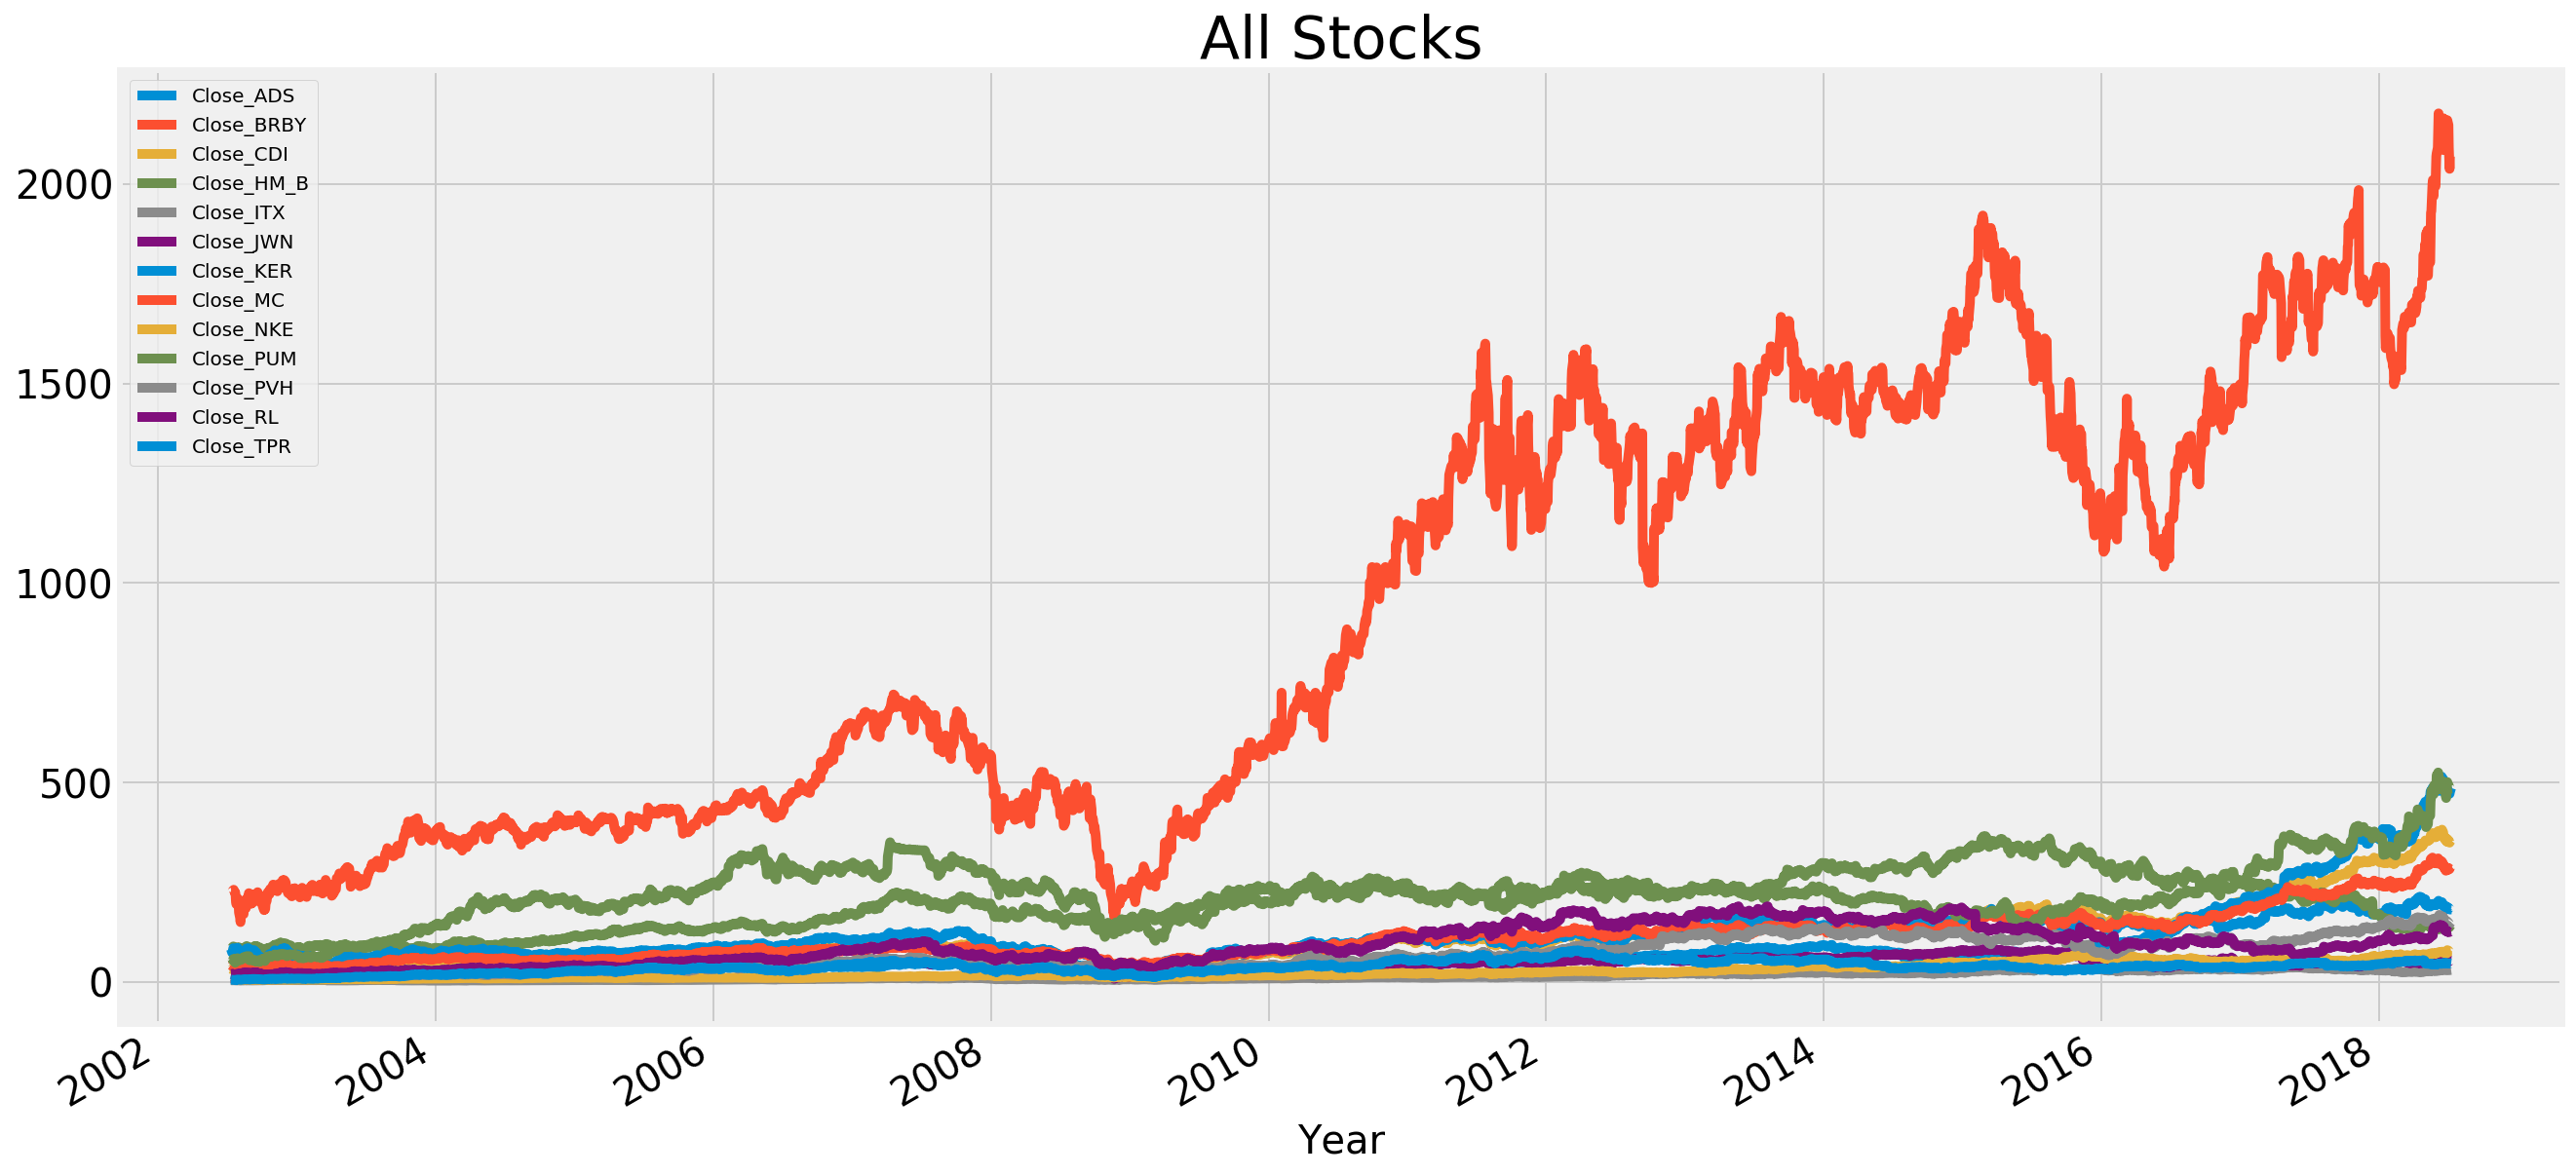

In [1074]:
closeprice_etf.plot(figsize=(20,10), linewidth=5, fontsize=20)
plt.title('All Stocks', fontsize=30)
plt.xlabel('Year', fontsize=20);

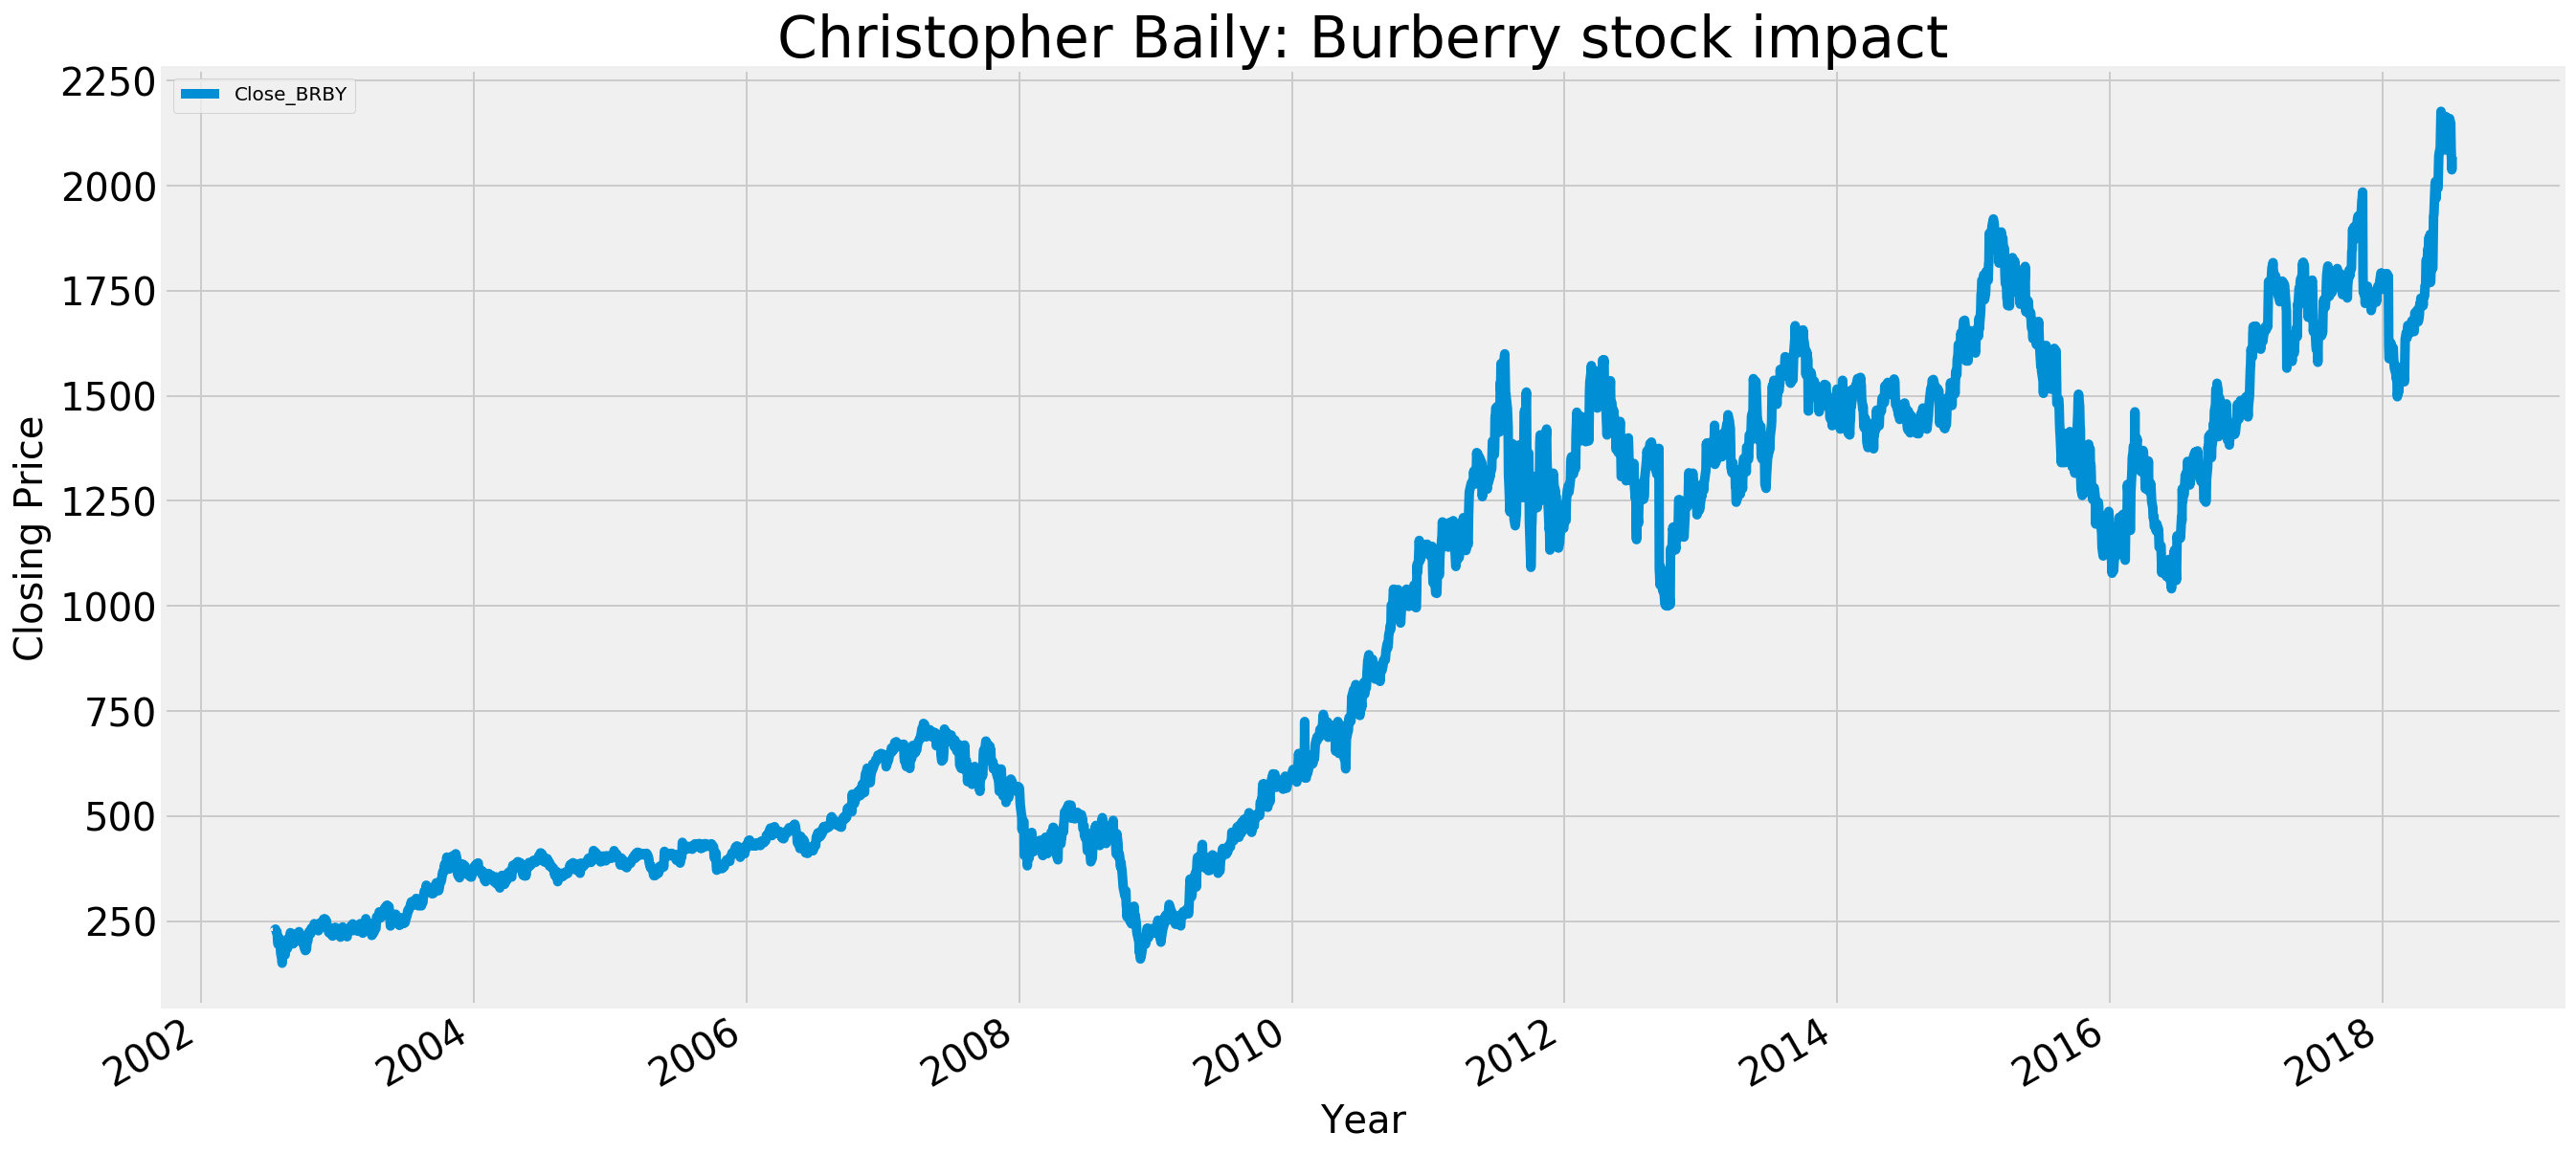

In [962]:
closeprice_etf[['Close_BRBY']].plot(figsize=(20,10), linewidth=5, fontsize=20)
plt.xlabel('Year', fontsize=20)
plt.ylabel('Closing Price', fontsize=20)
plt.title('Christopher Baily: Burberry stock impact', fontsize=30);

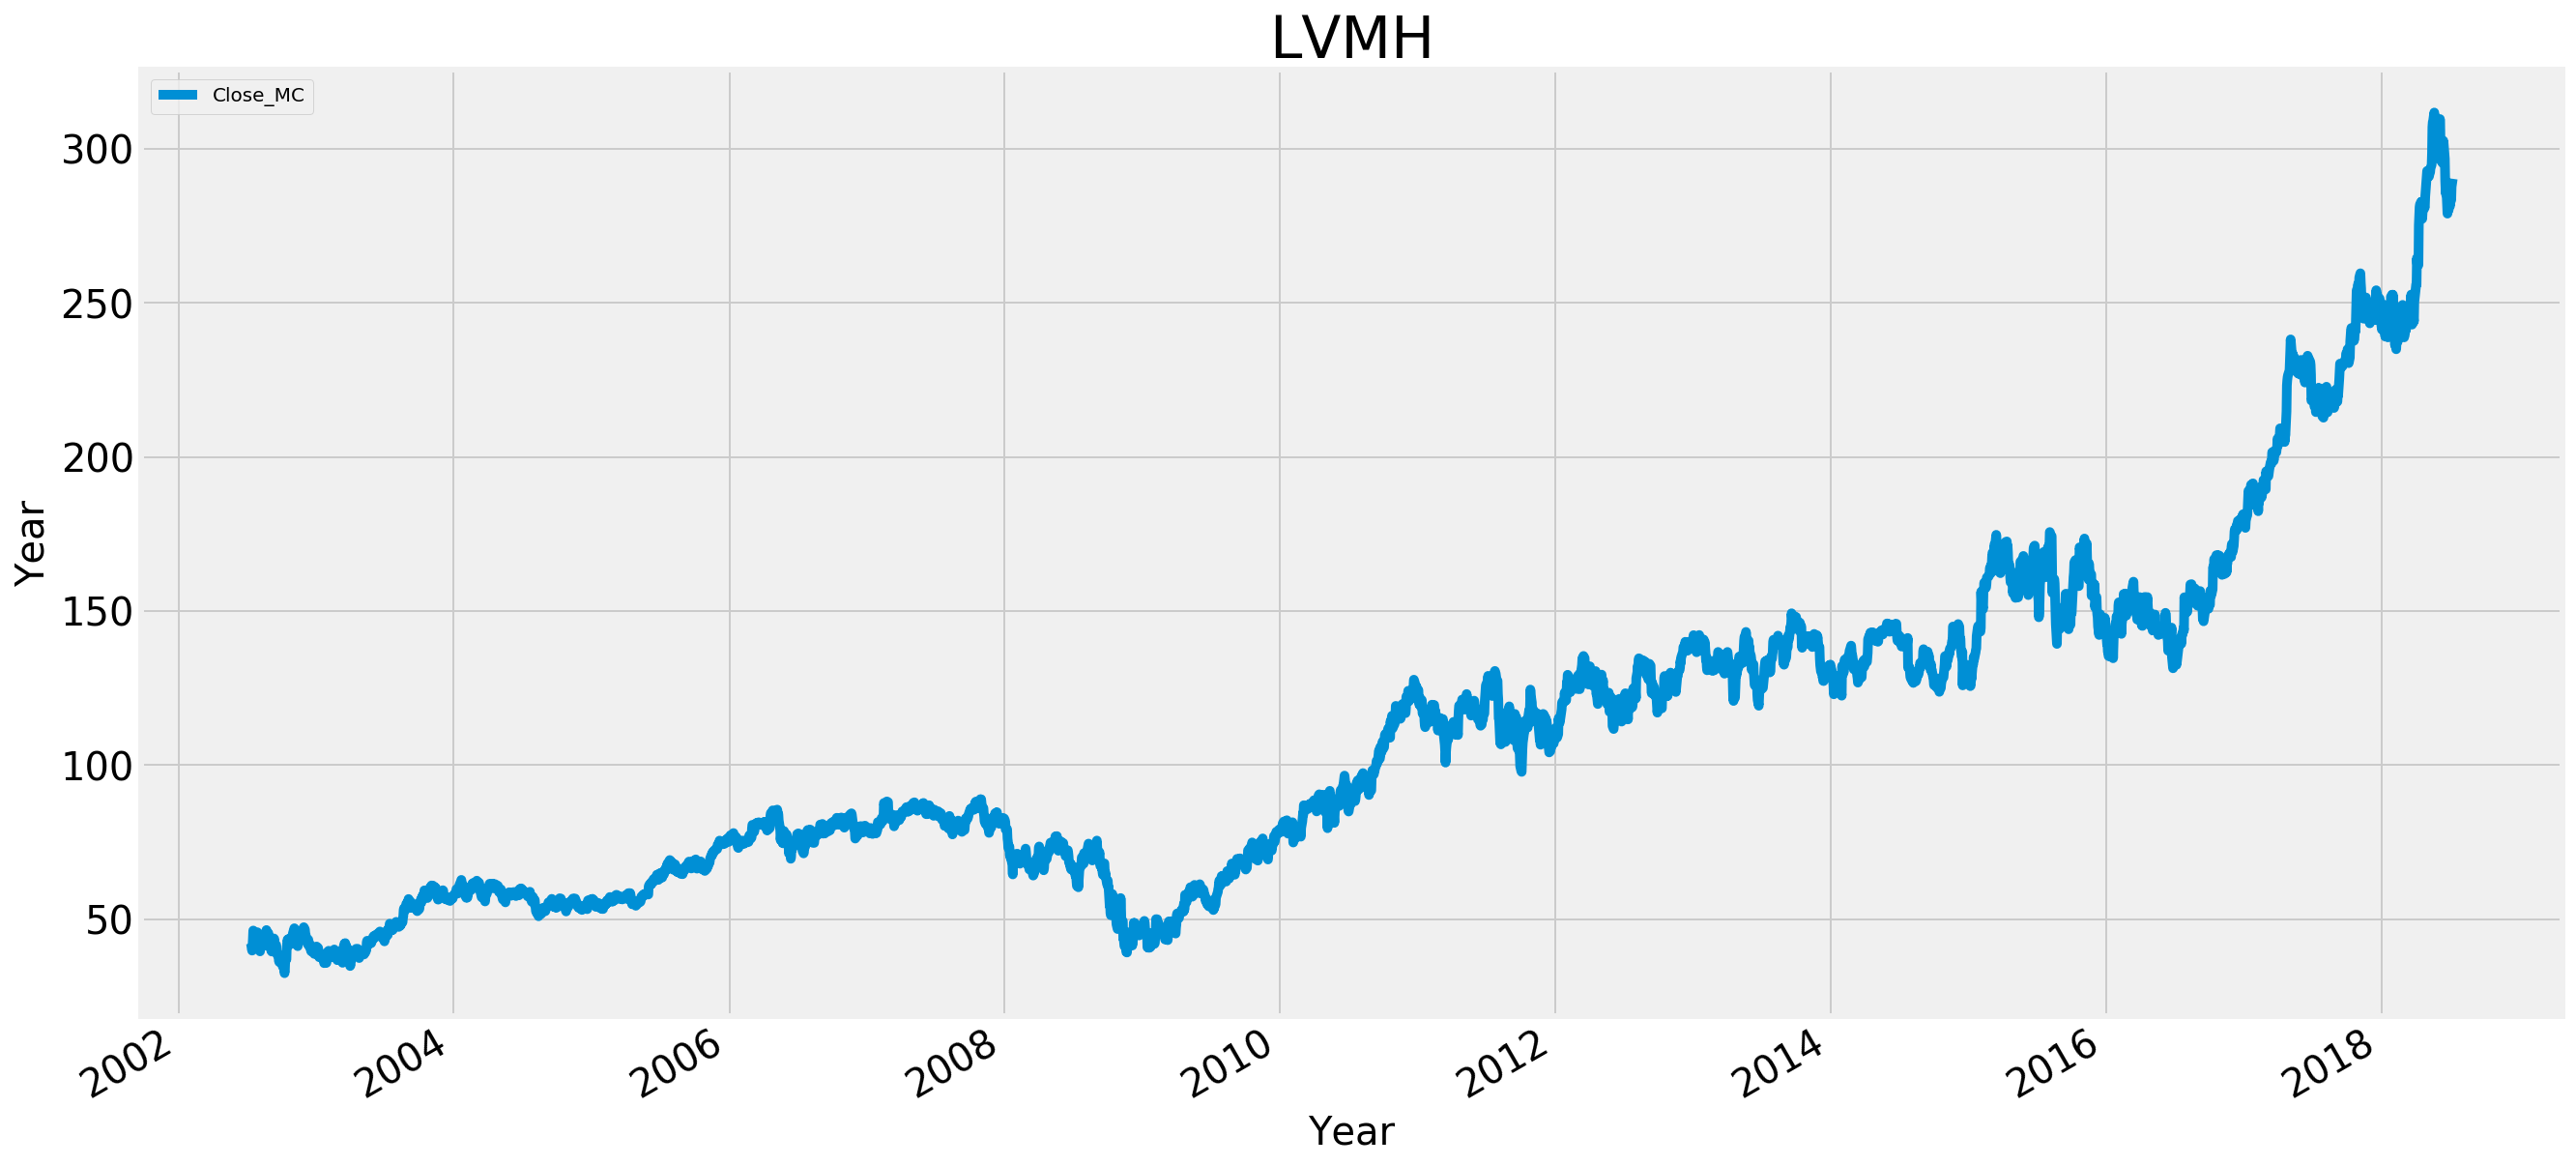

In [1076]:
closeprice_etf[['Close_MC']].plot(figsize=(20,10), linewidth=5, fontsize=20)
plt.xlabel('Year', fontsize=20)
plt.ylabel('Year', fontsize=20)
plt.title('LVMH', fontsize=30);

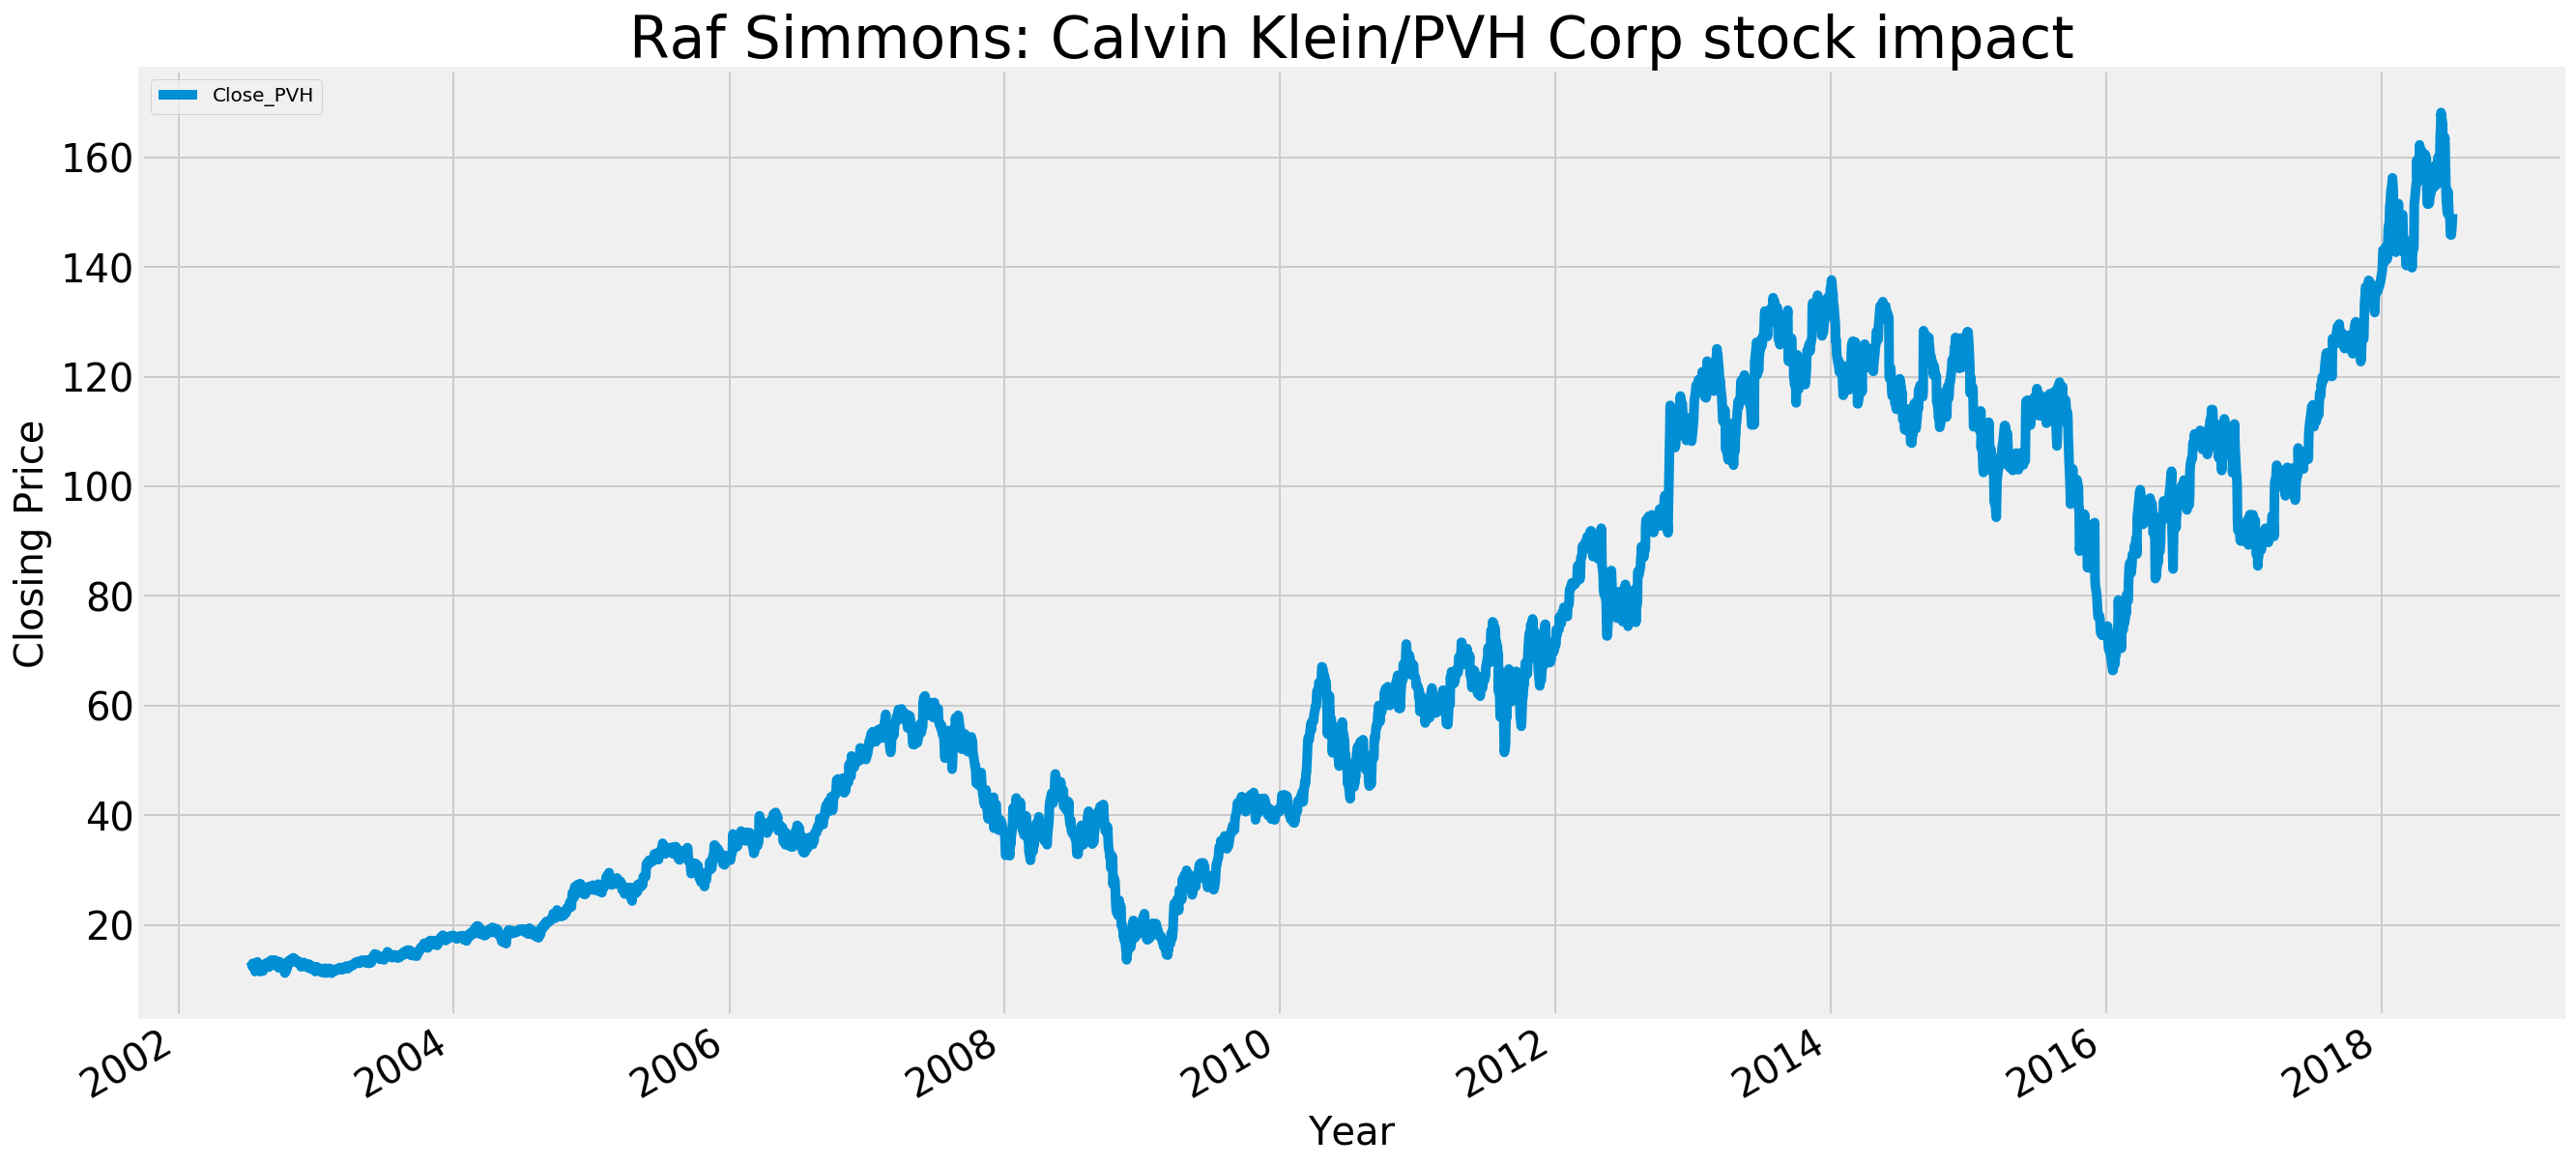

In [959]:
closeprice_etf[['Close_PVH']].plot(figsize=(20,10), linewidth=5, fontsize=20)
plt.xlabel('Year', fontsize=20)
plt.ylabel('Closing Price', fontsize=20)
plt.title('Raf Simmons: Calvin Klein/PVH Corp stock impact', fontsize=30);

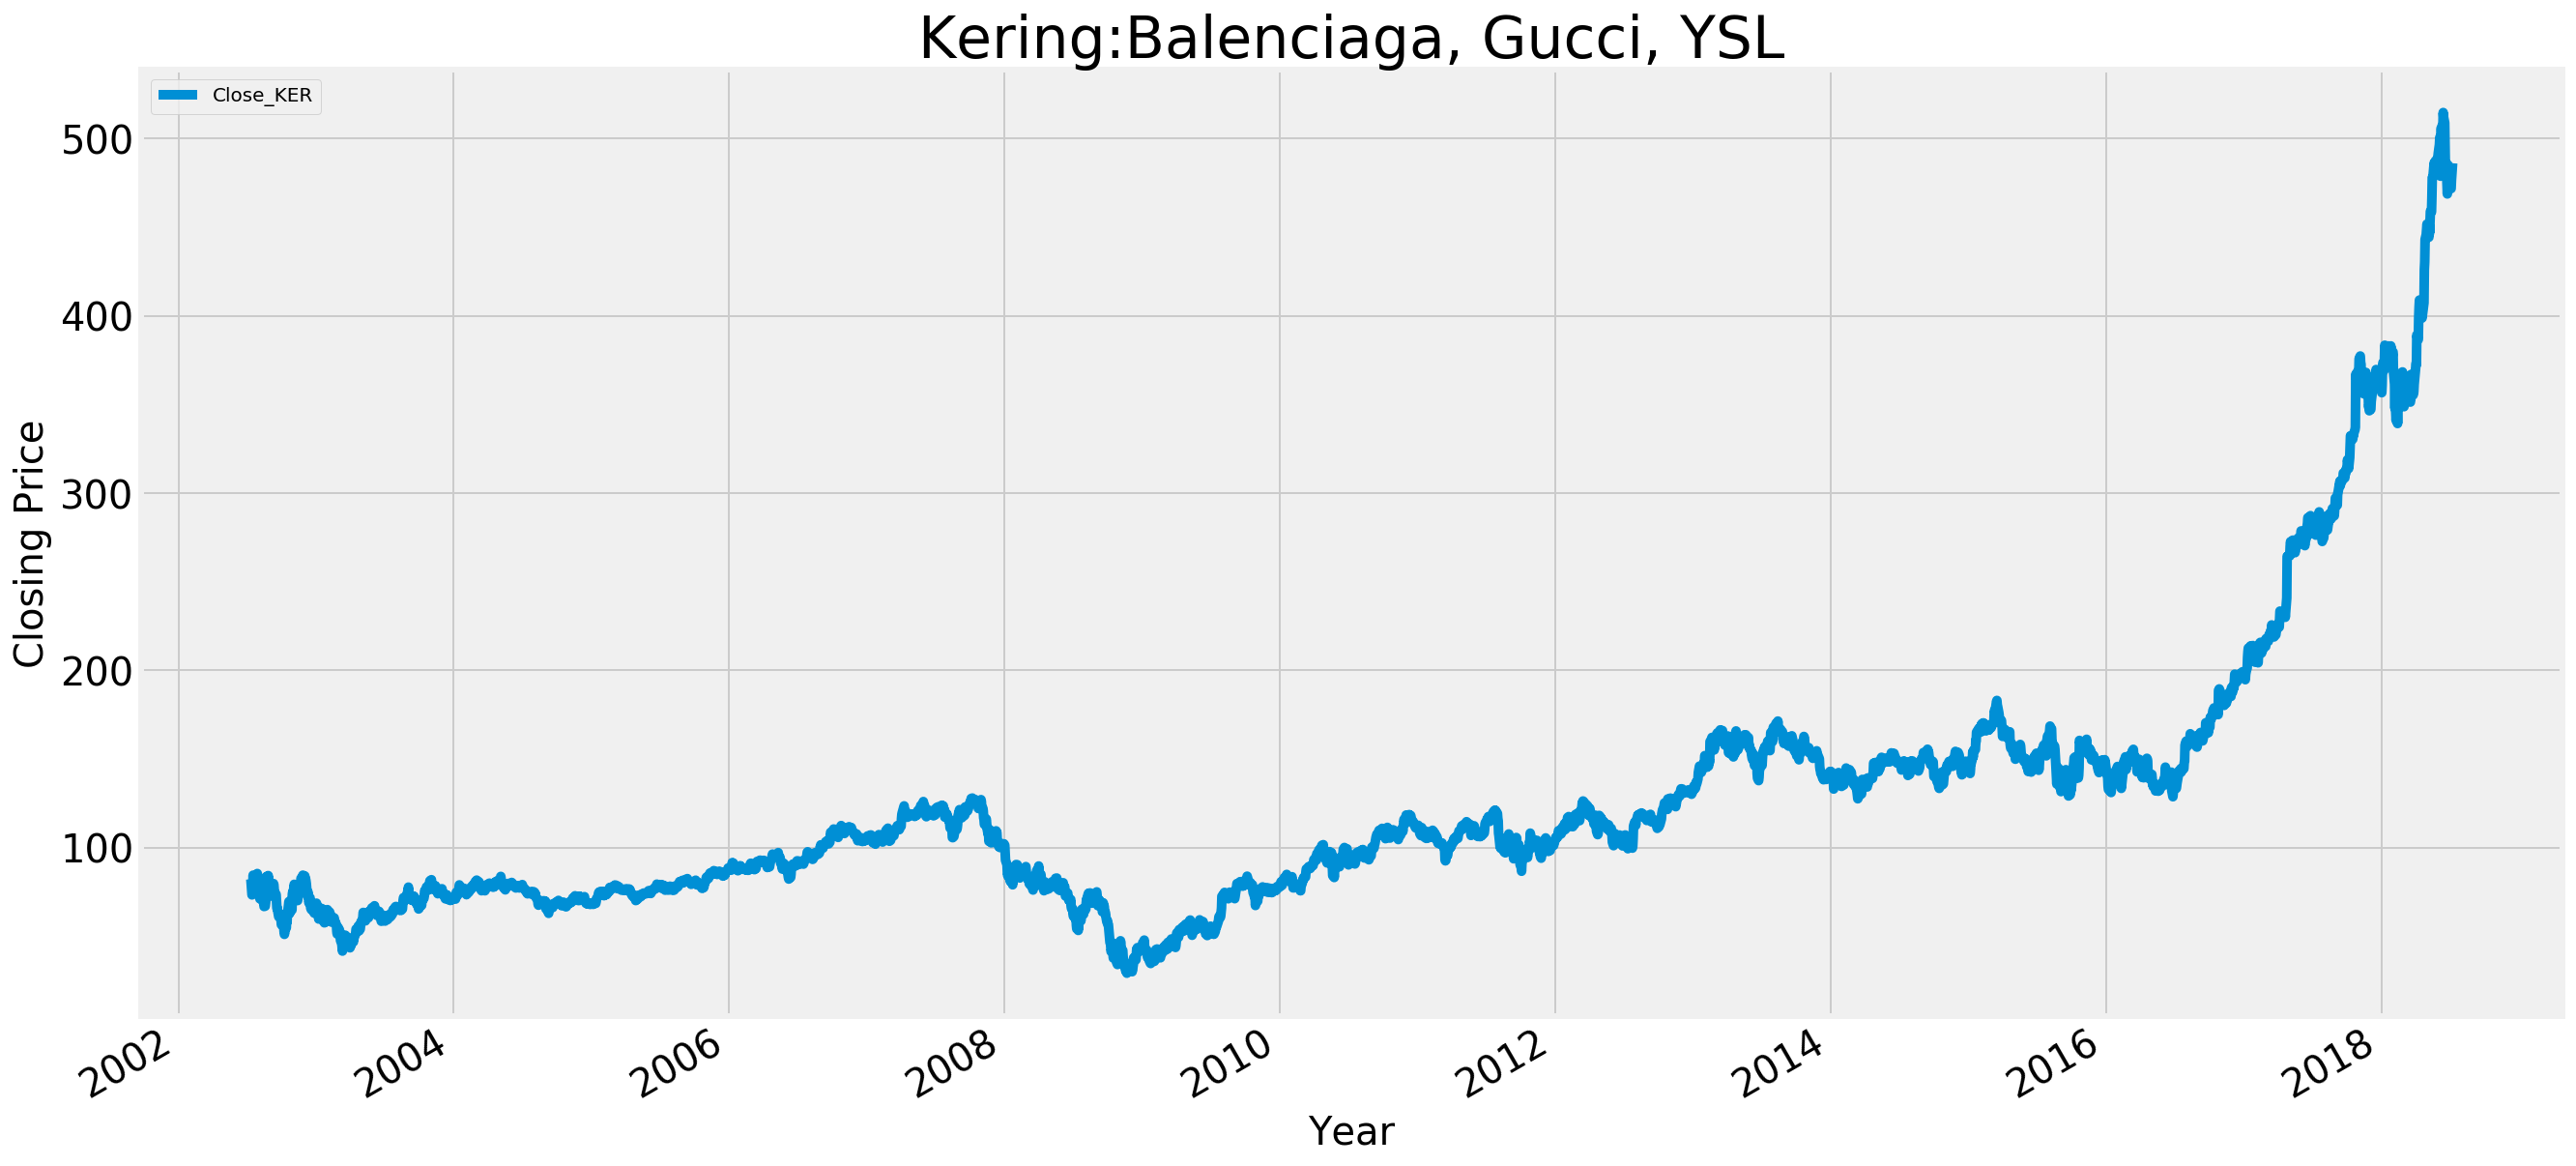

In [1077]:
closeprice_etf[['Close_KER']].plot(figsize=(20,10), linewidth=5, fontsize=20)
plt.xlabel('Year', fontsize=20)
plt.ylabel('Closing Price', fontsize=20)
plt.title('Kering:Balenciaga, Gucci, YSL', fontsize=30);

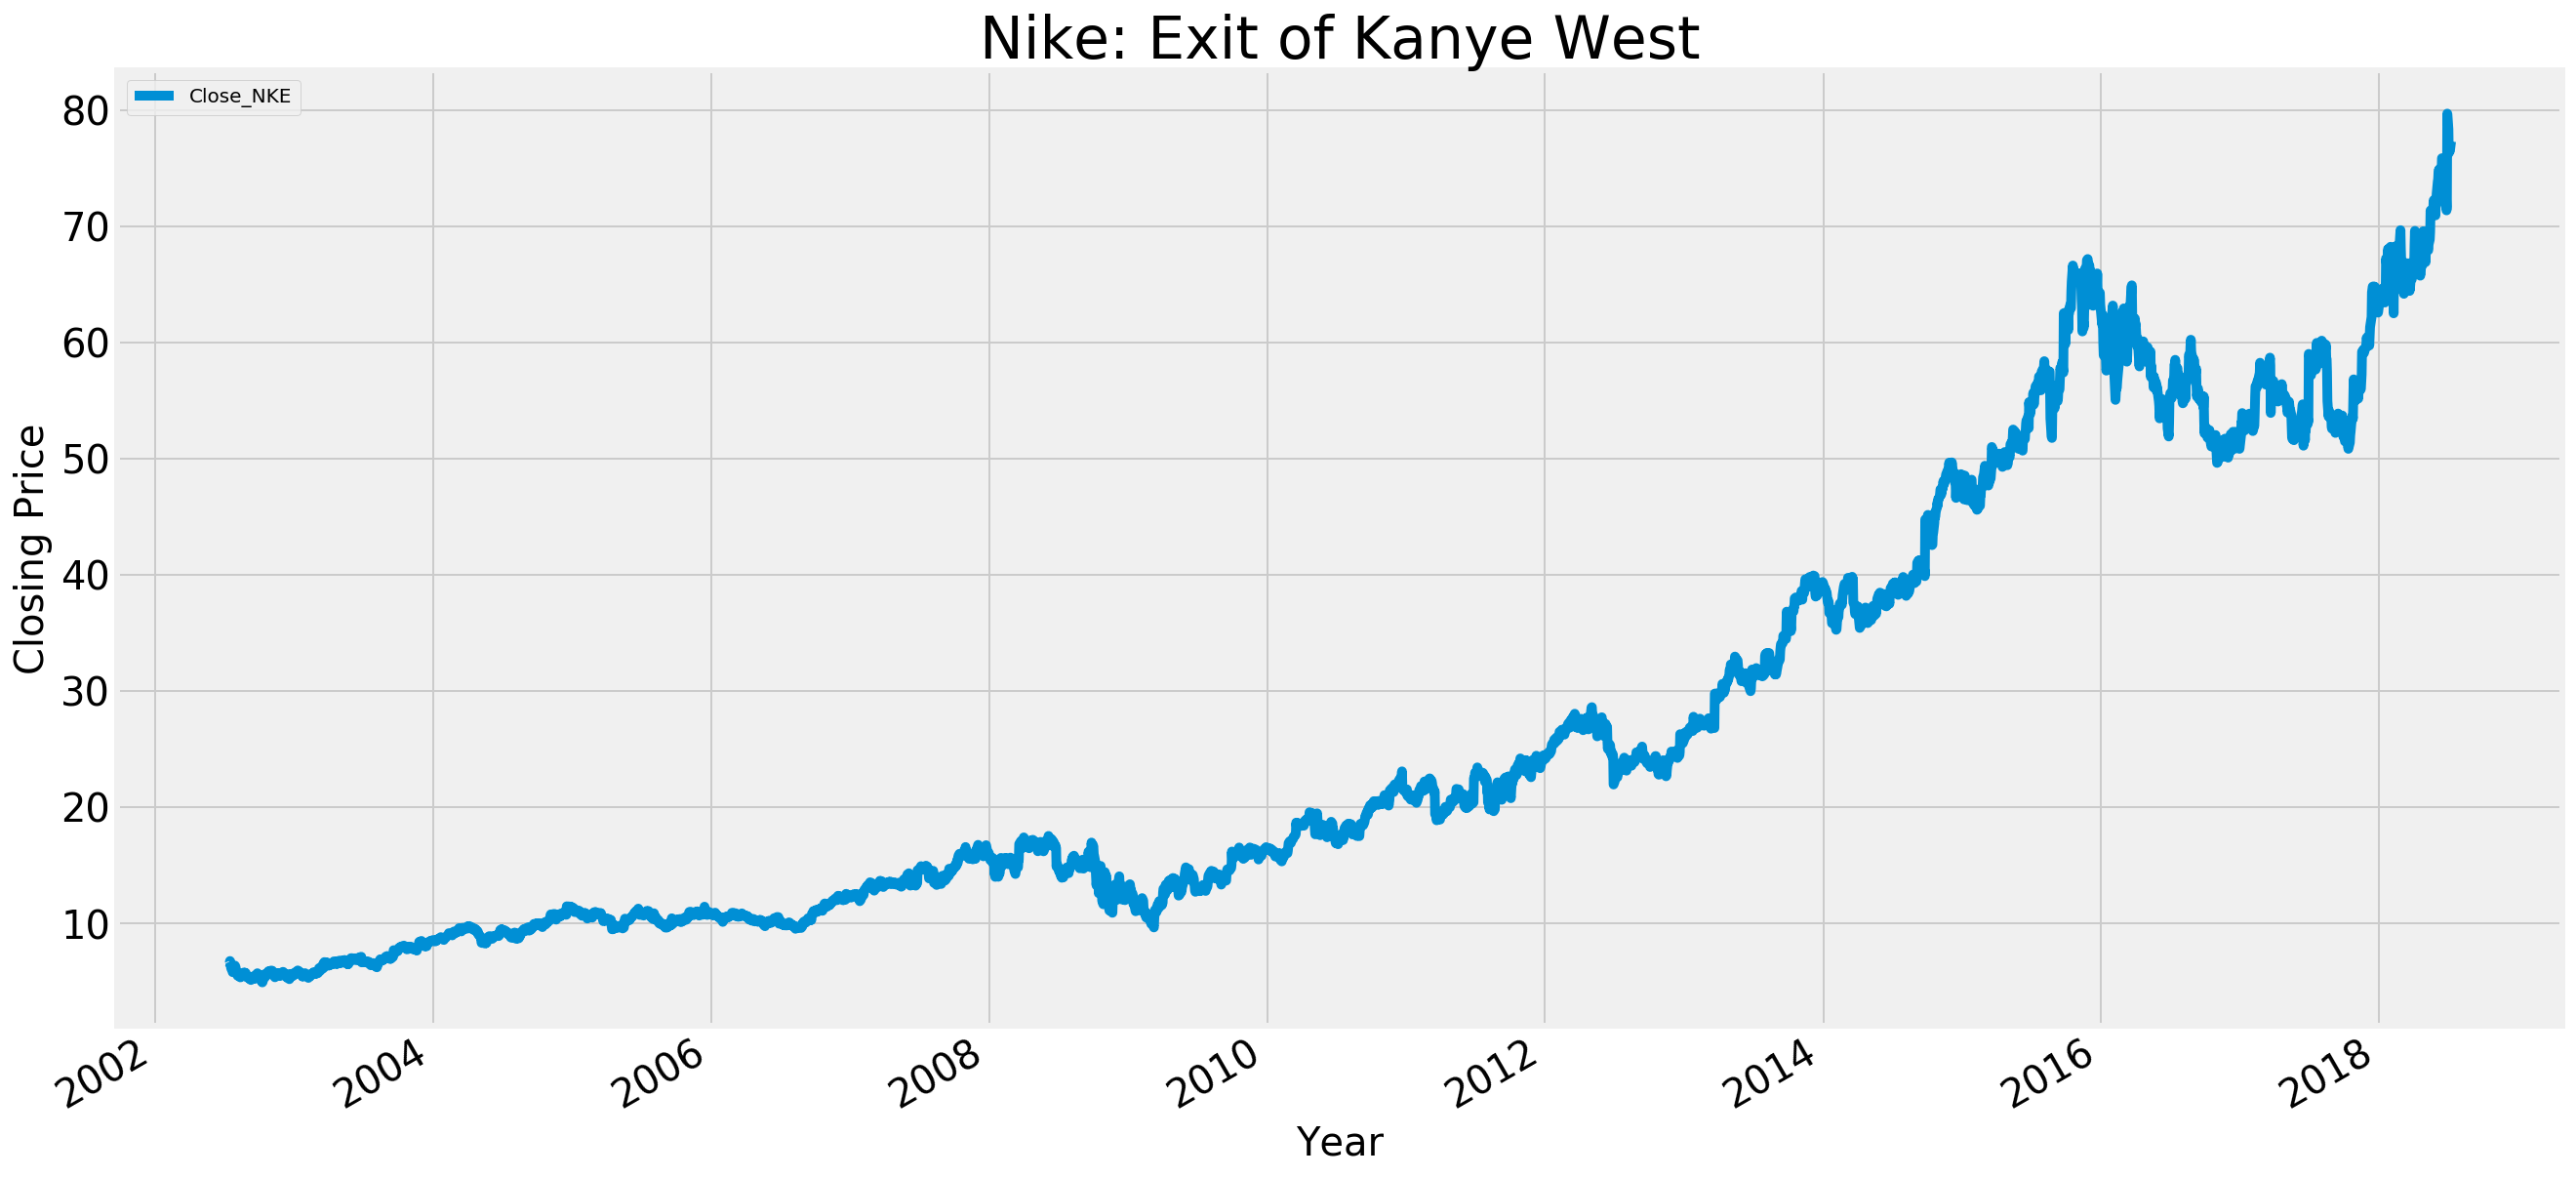

In [1078]:
closeprice_etf[['Close_NKE']].plot(figsize=(20,10), linewidth=5, fontsize=20)
plt.xlabel('Year', fontsize=20)
plt.ylabel('Closing Price', fontsize=20)
plt.title('Nike: Exit of Kanye West', fontsize=30);

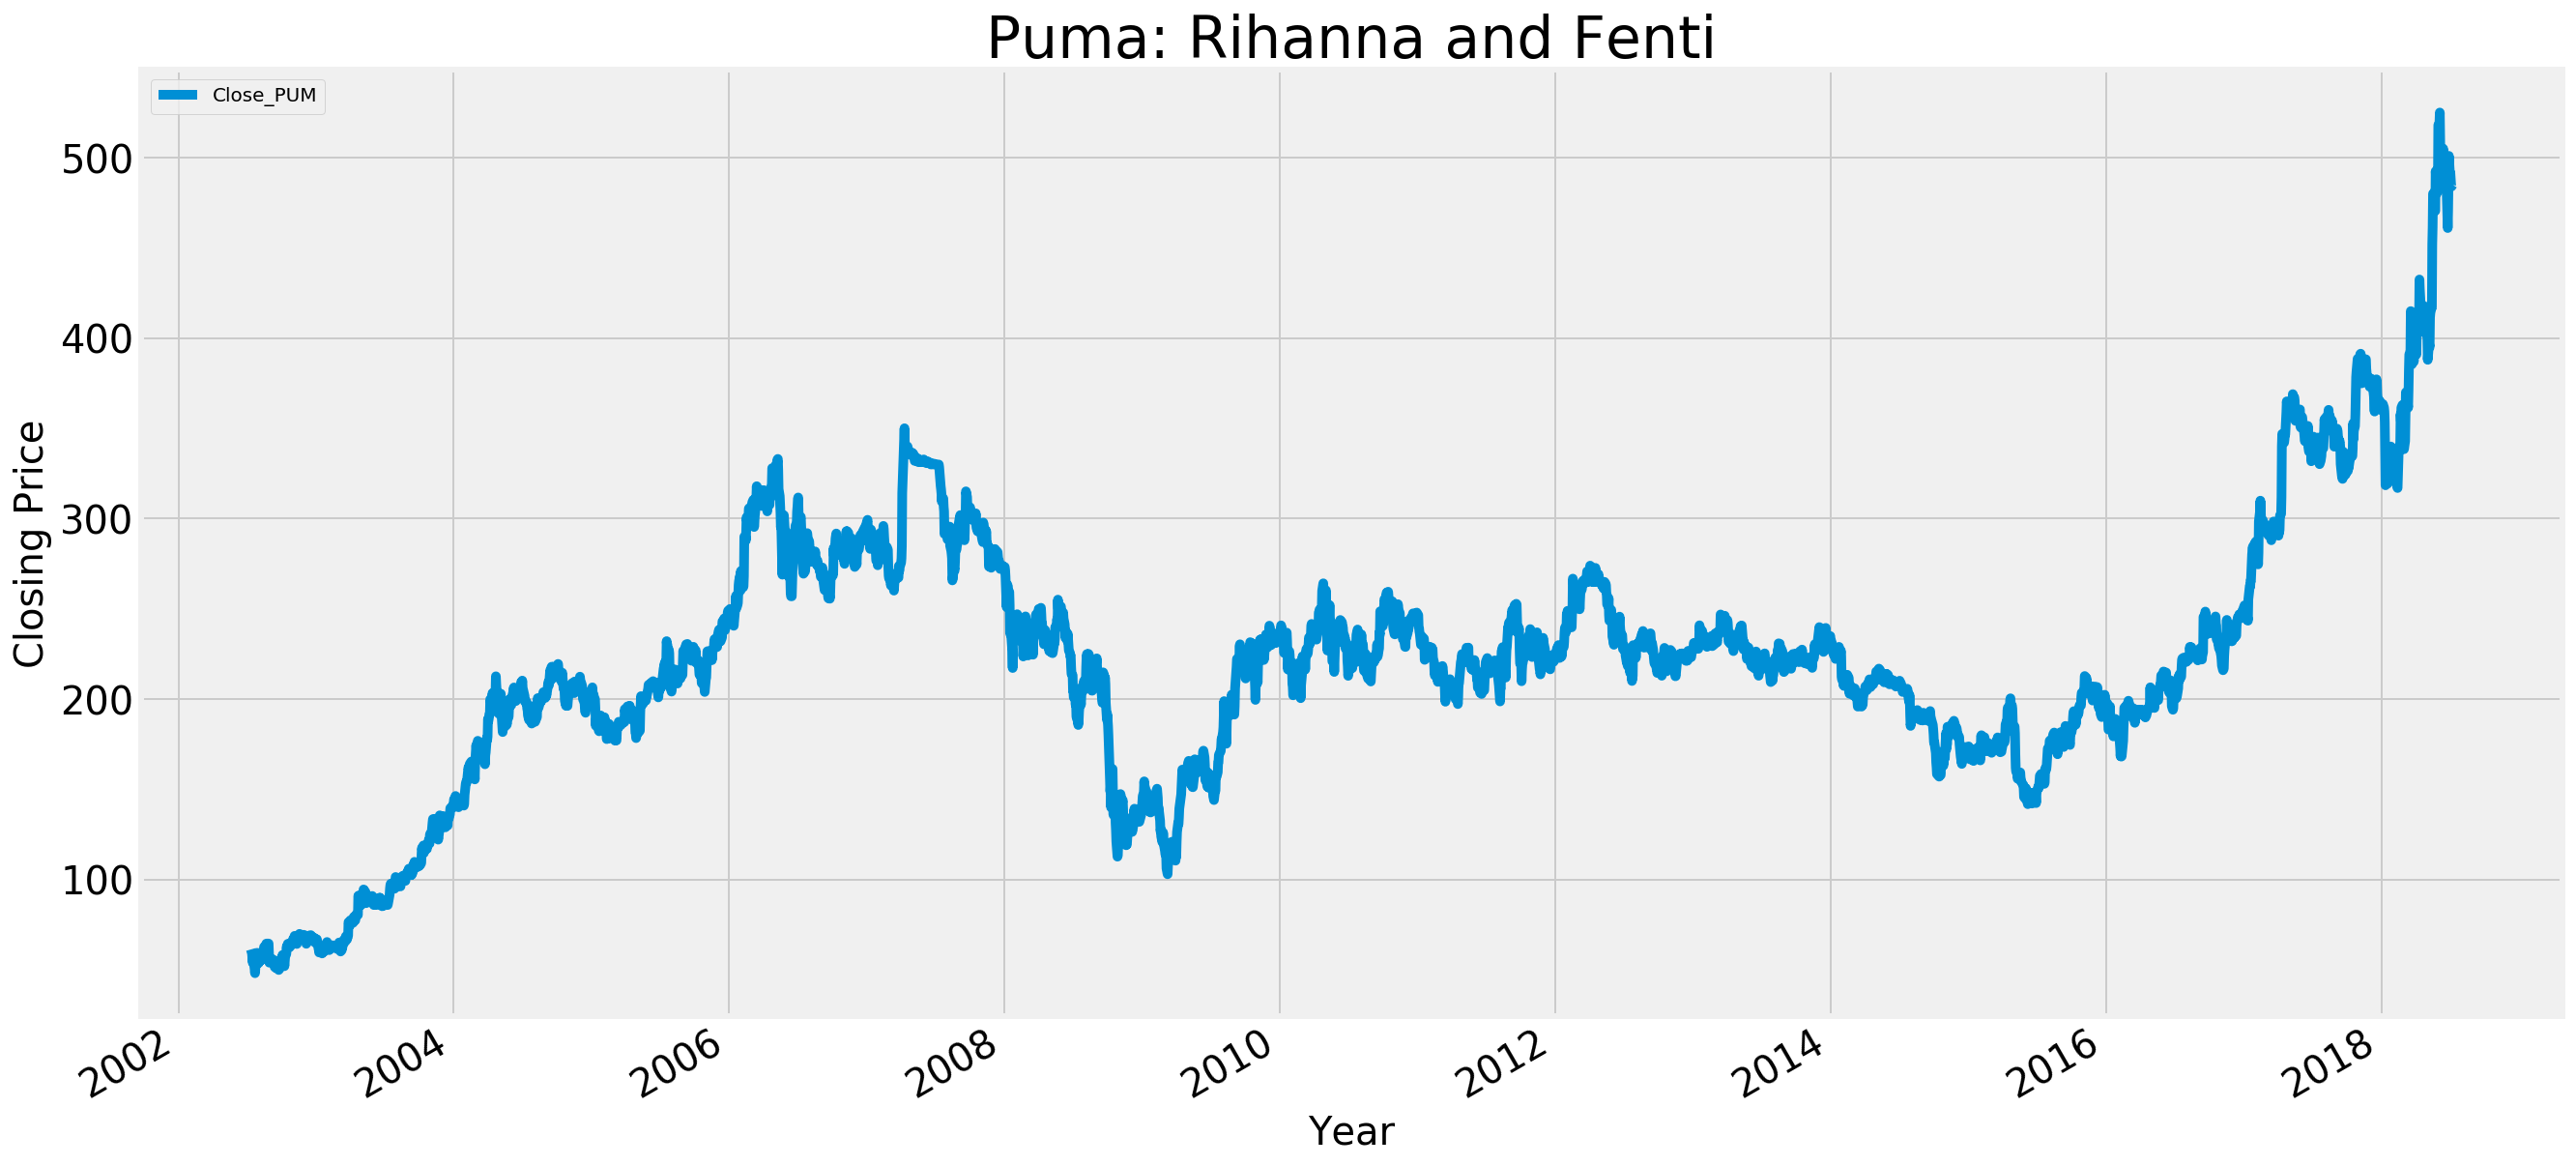

In [1079]:
closeprice_etf[['Close_PUM']].plot(figsize=(20,10), linewidth=5, fontsize=20)
plt.xlabel('Year', fontsize=20)
plt.ylabel('Closing Price', fontsize=20)
plt.title('Puma: Rihanna and Fenti', fontsize=30);

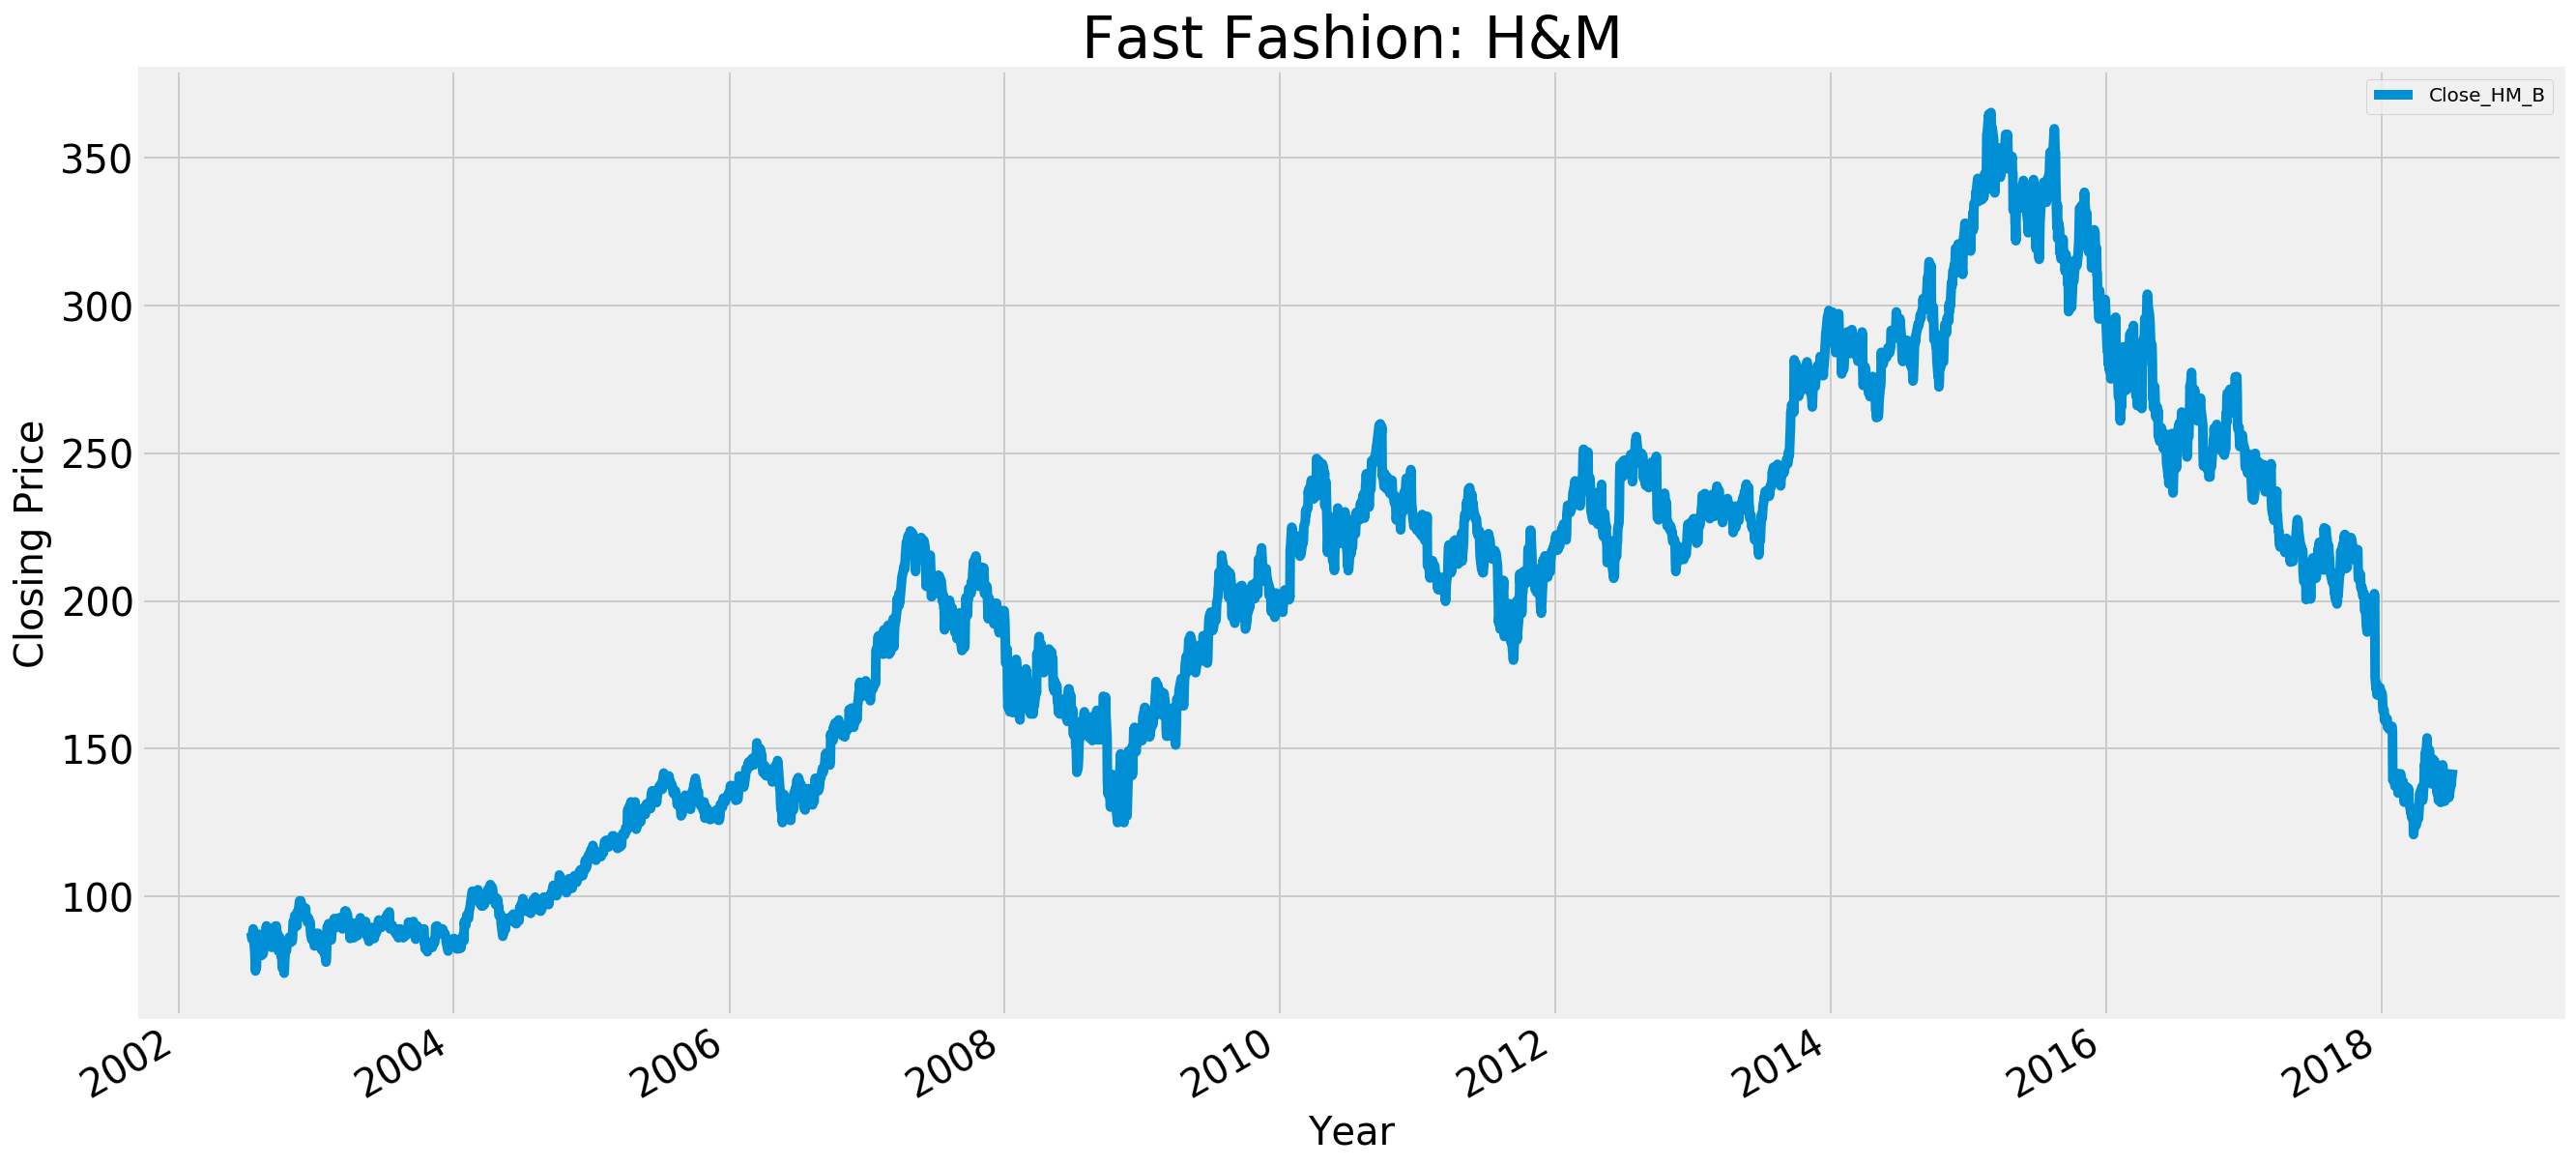

In [969]:
closeprice_etf[['Close_HM_B']].plot(figsize=(20,10), linewidth=5, fontsize=20)
plt.xlabel('Year', fontsize=20)
plt.ylabel('Closing Price', fontsize=20)
plt.title('Fast Fashion: H&M', fontsize=30);

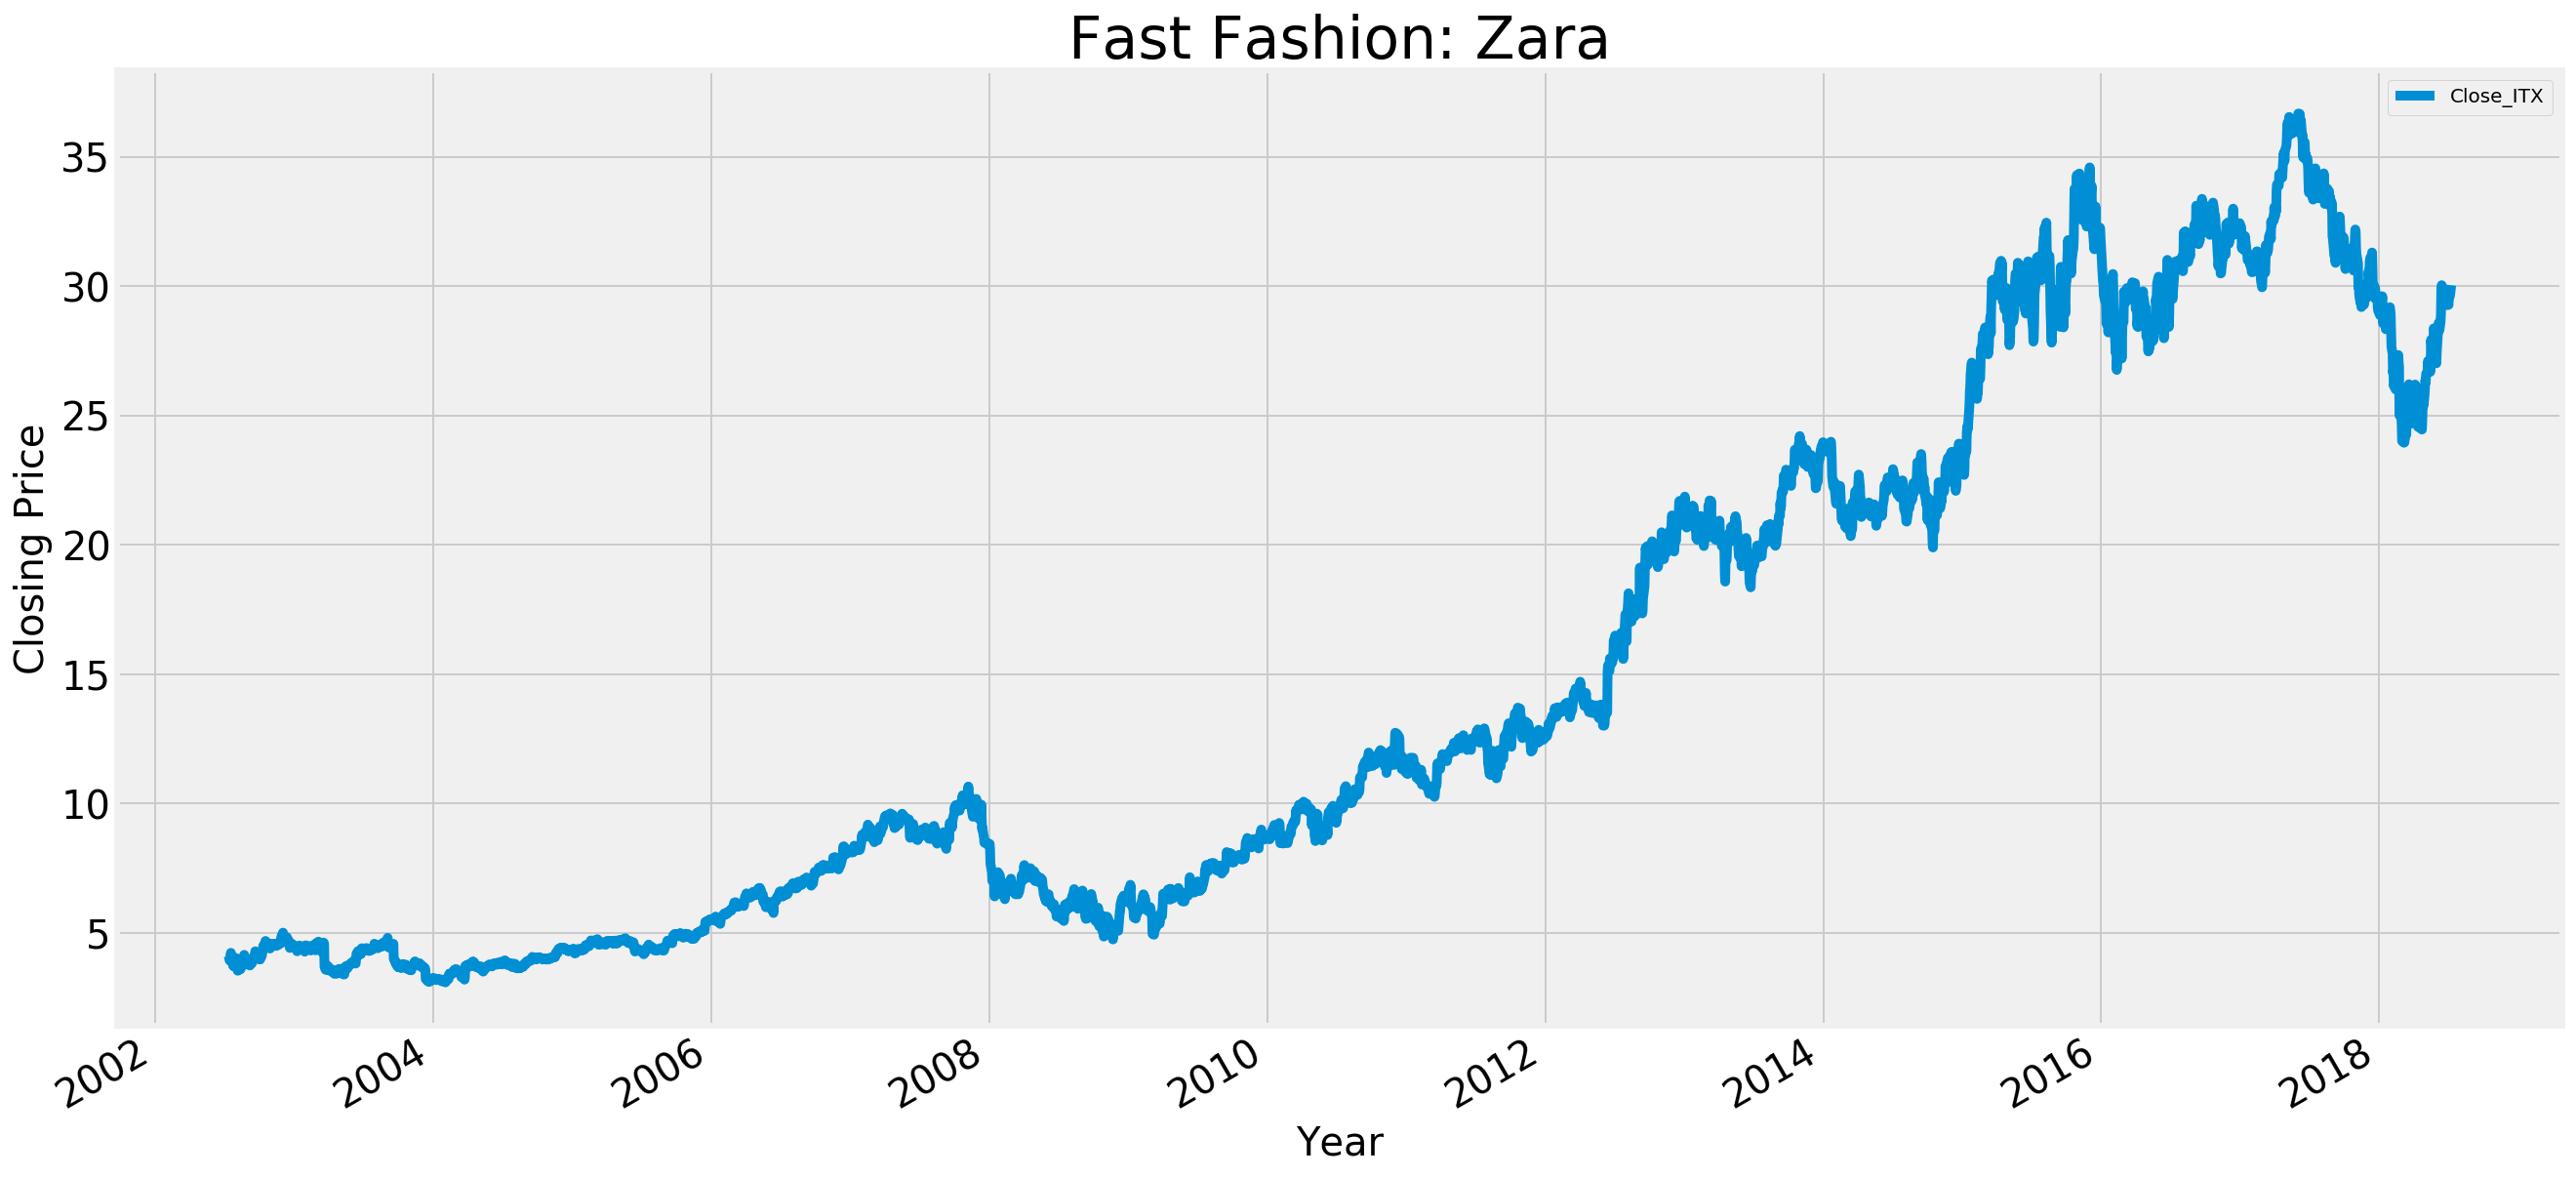

In [970]:
closeprice_etf[['Close_ITX']].plot(figsize=(20,10), linewidth=5, fontsize=20)
plt.xlabel('Year', fontsize=20)
plt.ylabel('Closing Price', fontsize=20)
plt.title('Fast Fashion: Zara', fontsize=30);

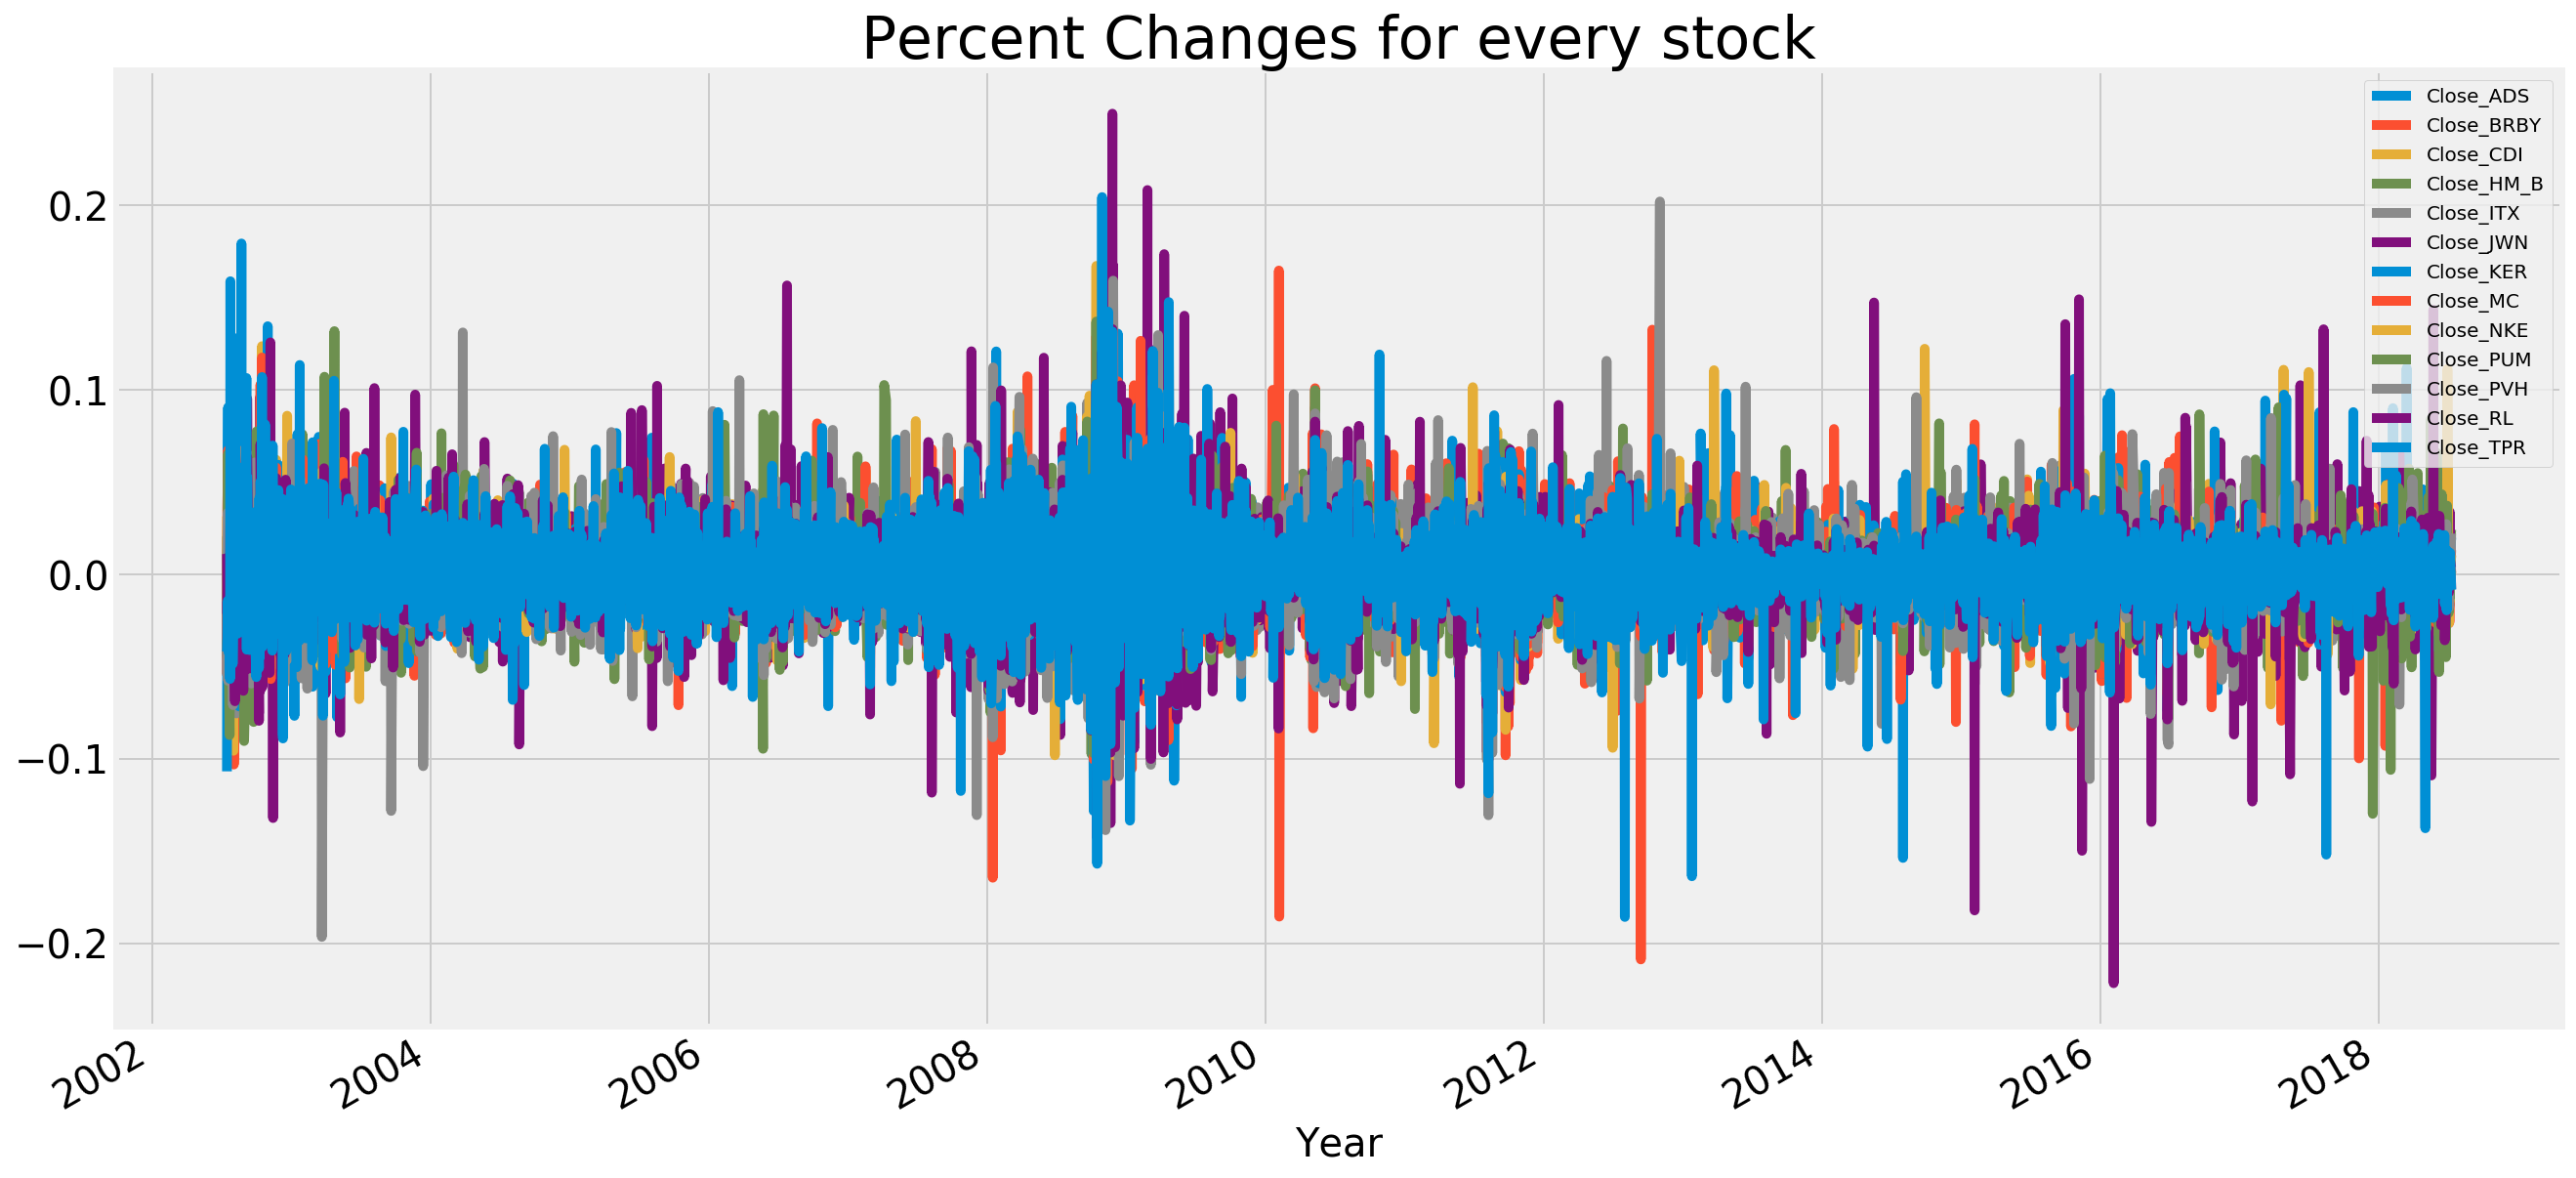

In [1080]:
pct_change_df.plot(figsize=(20,10), linewidth=5, fontsize=20)
plt.title('Percent Changes for every stock', fontsize=30)
plt.xlabel('Year', fontsize=20);

Text(0.5,1,'Christopher Baily: Burberry stock vol')

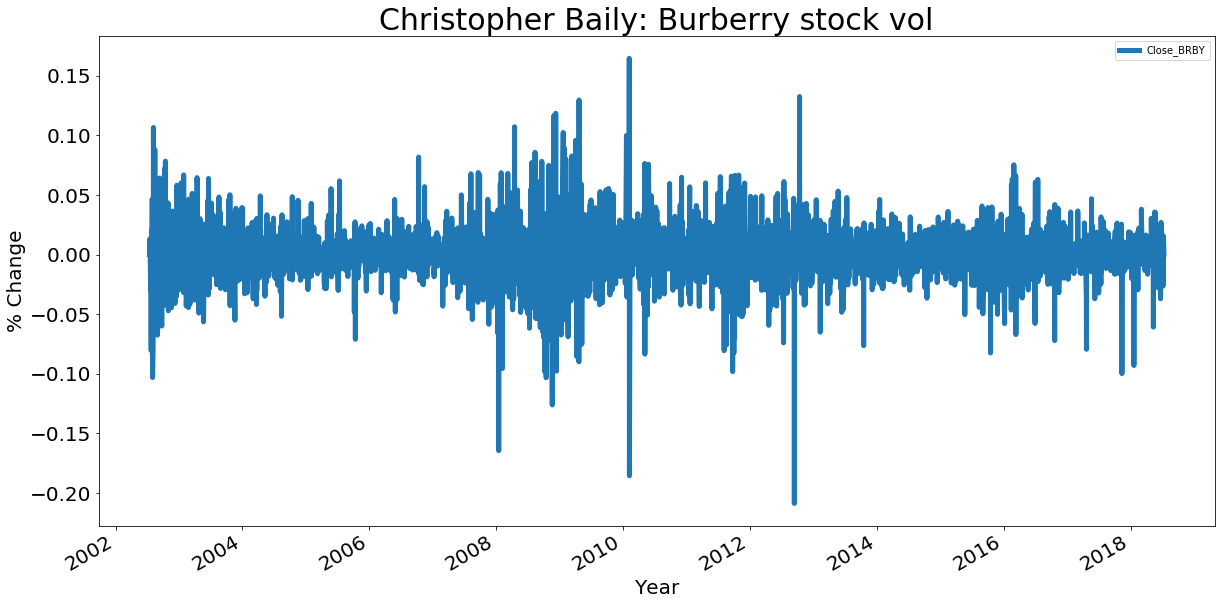

In [253]:
pct_change_df[['Close_BRBY']].plot(figsize=(20,10), linewidth=5, fontsize=20)
plt.xlabel('Year', fontsize=20)
plt.ylabel('% Change', fontsize=20)
plt.title('Christopher Baily: Burberry stock vol', fontsize=30)

## Trial run (LVMH, XgBoost Model)

In [685]:
lvmh_stockpred_df = closeprice_etf['Close_MC']

In [ ]:
lvmh_series = closeprice_etf['Close_MC']

In [686]:
lvmh_stockpred_df = lvmh_stockpred_df.to_frame()

In [687]:
type(lvmh_stockpred_df)

pandas.core.frame.DataFrame

In [688]:
lvmh_stockpred_df.head(1)

Close_MC
2002-07-12     42.09

In [689]:
Predictors = pd.DataFrame({"sma2":lvmh_stockpred_df['Close_MC'].rolling(window=2).mean()})

In [690]:
Predictors.head()

sma2
2002-07-12        NaN
2002-07-15  40.950001
2002-07-16  40.530000
2002-07-17  42.325001
2002-07-18  44.860001

In [691]:
Predictors["sma2_1"] = Predictors.sma2.shift(1)

In [692]:
Predictors['sma2_increment'] = Predictors.sma2.diff()

In [693]:
Predictors['sma2_1_increment'] = Predictors.sma2_1.diff()

In [694]:
Predictors['close_1'] = lvmh_stockpred_df['Close_MC'].shift(1)

In [695]:
Predictors['close_incr'] = lvmh_stockpred_df['Close_MC'] - lvmh_stockpred_df['Close_MC'].shift(1)

In [696]:
Predictors['Close'] = lvmh_stockpred_df['Close_MC']

In [697]:
Predictors = Predictors.dropna()

In [698]:
Predictors.head()

sma2     sma2_1  sma2_increment  sma2_1_increment    close_1  \
2002-07-17  42.325001  40.530000        1.795001         -0.420000  41.250000   
2002-07-18  44.860001  42.325001        2.535000          1.795001  43.400002   
2002-07-19  45.635001  44.860001        0.775000          2.535000  46.320000   
2002-07-22  43.635001  45.635001       -2.000000          0.775000  44.950001   
2002-07-23  41.640000  43.635001       -1.995001         -2.000000  42.320000   

            close_incr      Close  
2002-07-17    2.150002  43.400002  
2002-07-18    2.919998  46.320000  
2002-07-19   -1.369999  44.950001  
2002-07-22   -2.630001  42.320000  
2002-07-23   -1.360001  40.959999

In [711]:
target = pd.DataFrame({'Value':Predictors.sma2.shift(-1) - Predictors.sma2}).dropna()

In [712]:
X = pd.merge(Predictors, target,left_index=True,right_index=True)[Predictors.columns]
y = pd.merge(Predictors, target,left_index=True,right_index=True)[target.columns]

In [713]:
train_samples = int(X.shape[0] * 0.70)

X_train = X.iloc[:train_samples]
X_test = X.iloc[train_samples:]

y_train = y.iloc[:train_samples]
y_test = y.iloc[train_samples:]

In [714]:
def getBinary(val):
    if val>0:
        return 1
    else:
        return 0

In [715]:
# y_train.mean()

In [716]:
# y_train.head()

In [717]:
y_test.shape
X_test.shape

(1197, 7)

In [721]:
# y_test.head

In [719]:
y_test_binary = pd.DataFrame(y_test['Value'].apply(getBinary))

In [915]:
classifier = XGBClassifier(gamma=0.15, n_estimators=150, base_score=.70, colsample_bytree=.8,learning_rate=0.3)

xgbmodel = classifier.fit(X_train, y_train.Value.apply(getBinary))

y_predicted = xgbModel.predict(X_test)
y_predicted_binary = [1 if yp >=0.5 else 0 for yp in y_predicted]

print(accuracy_score(y_test_binary, y_predicted_binary))

0.6532999164578112


In [364]:
from sklearn.metrics import confusion_matrix, classification_report

In [363]:
confusion_matrix(y_test_binary, y_predicted_binary)

array([[375, 196],
       [120, 506]])

In [366]:
confusion_matrix(y_test_binary, y_predicted_binary)
print(classification_report(y_test_binary, y_predicted_binary))

             precision    recall  f1-score   support

          0       0.76      0.66      0.70       571
          1       0.72      0.81      0.76       626

avg / total       0.74      0.74      0.73      1197



In [367]:
626/1197

0.5229741019214703

<Container object of 7 artists>

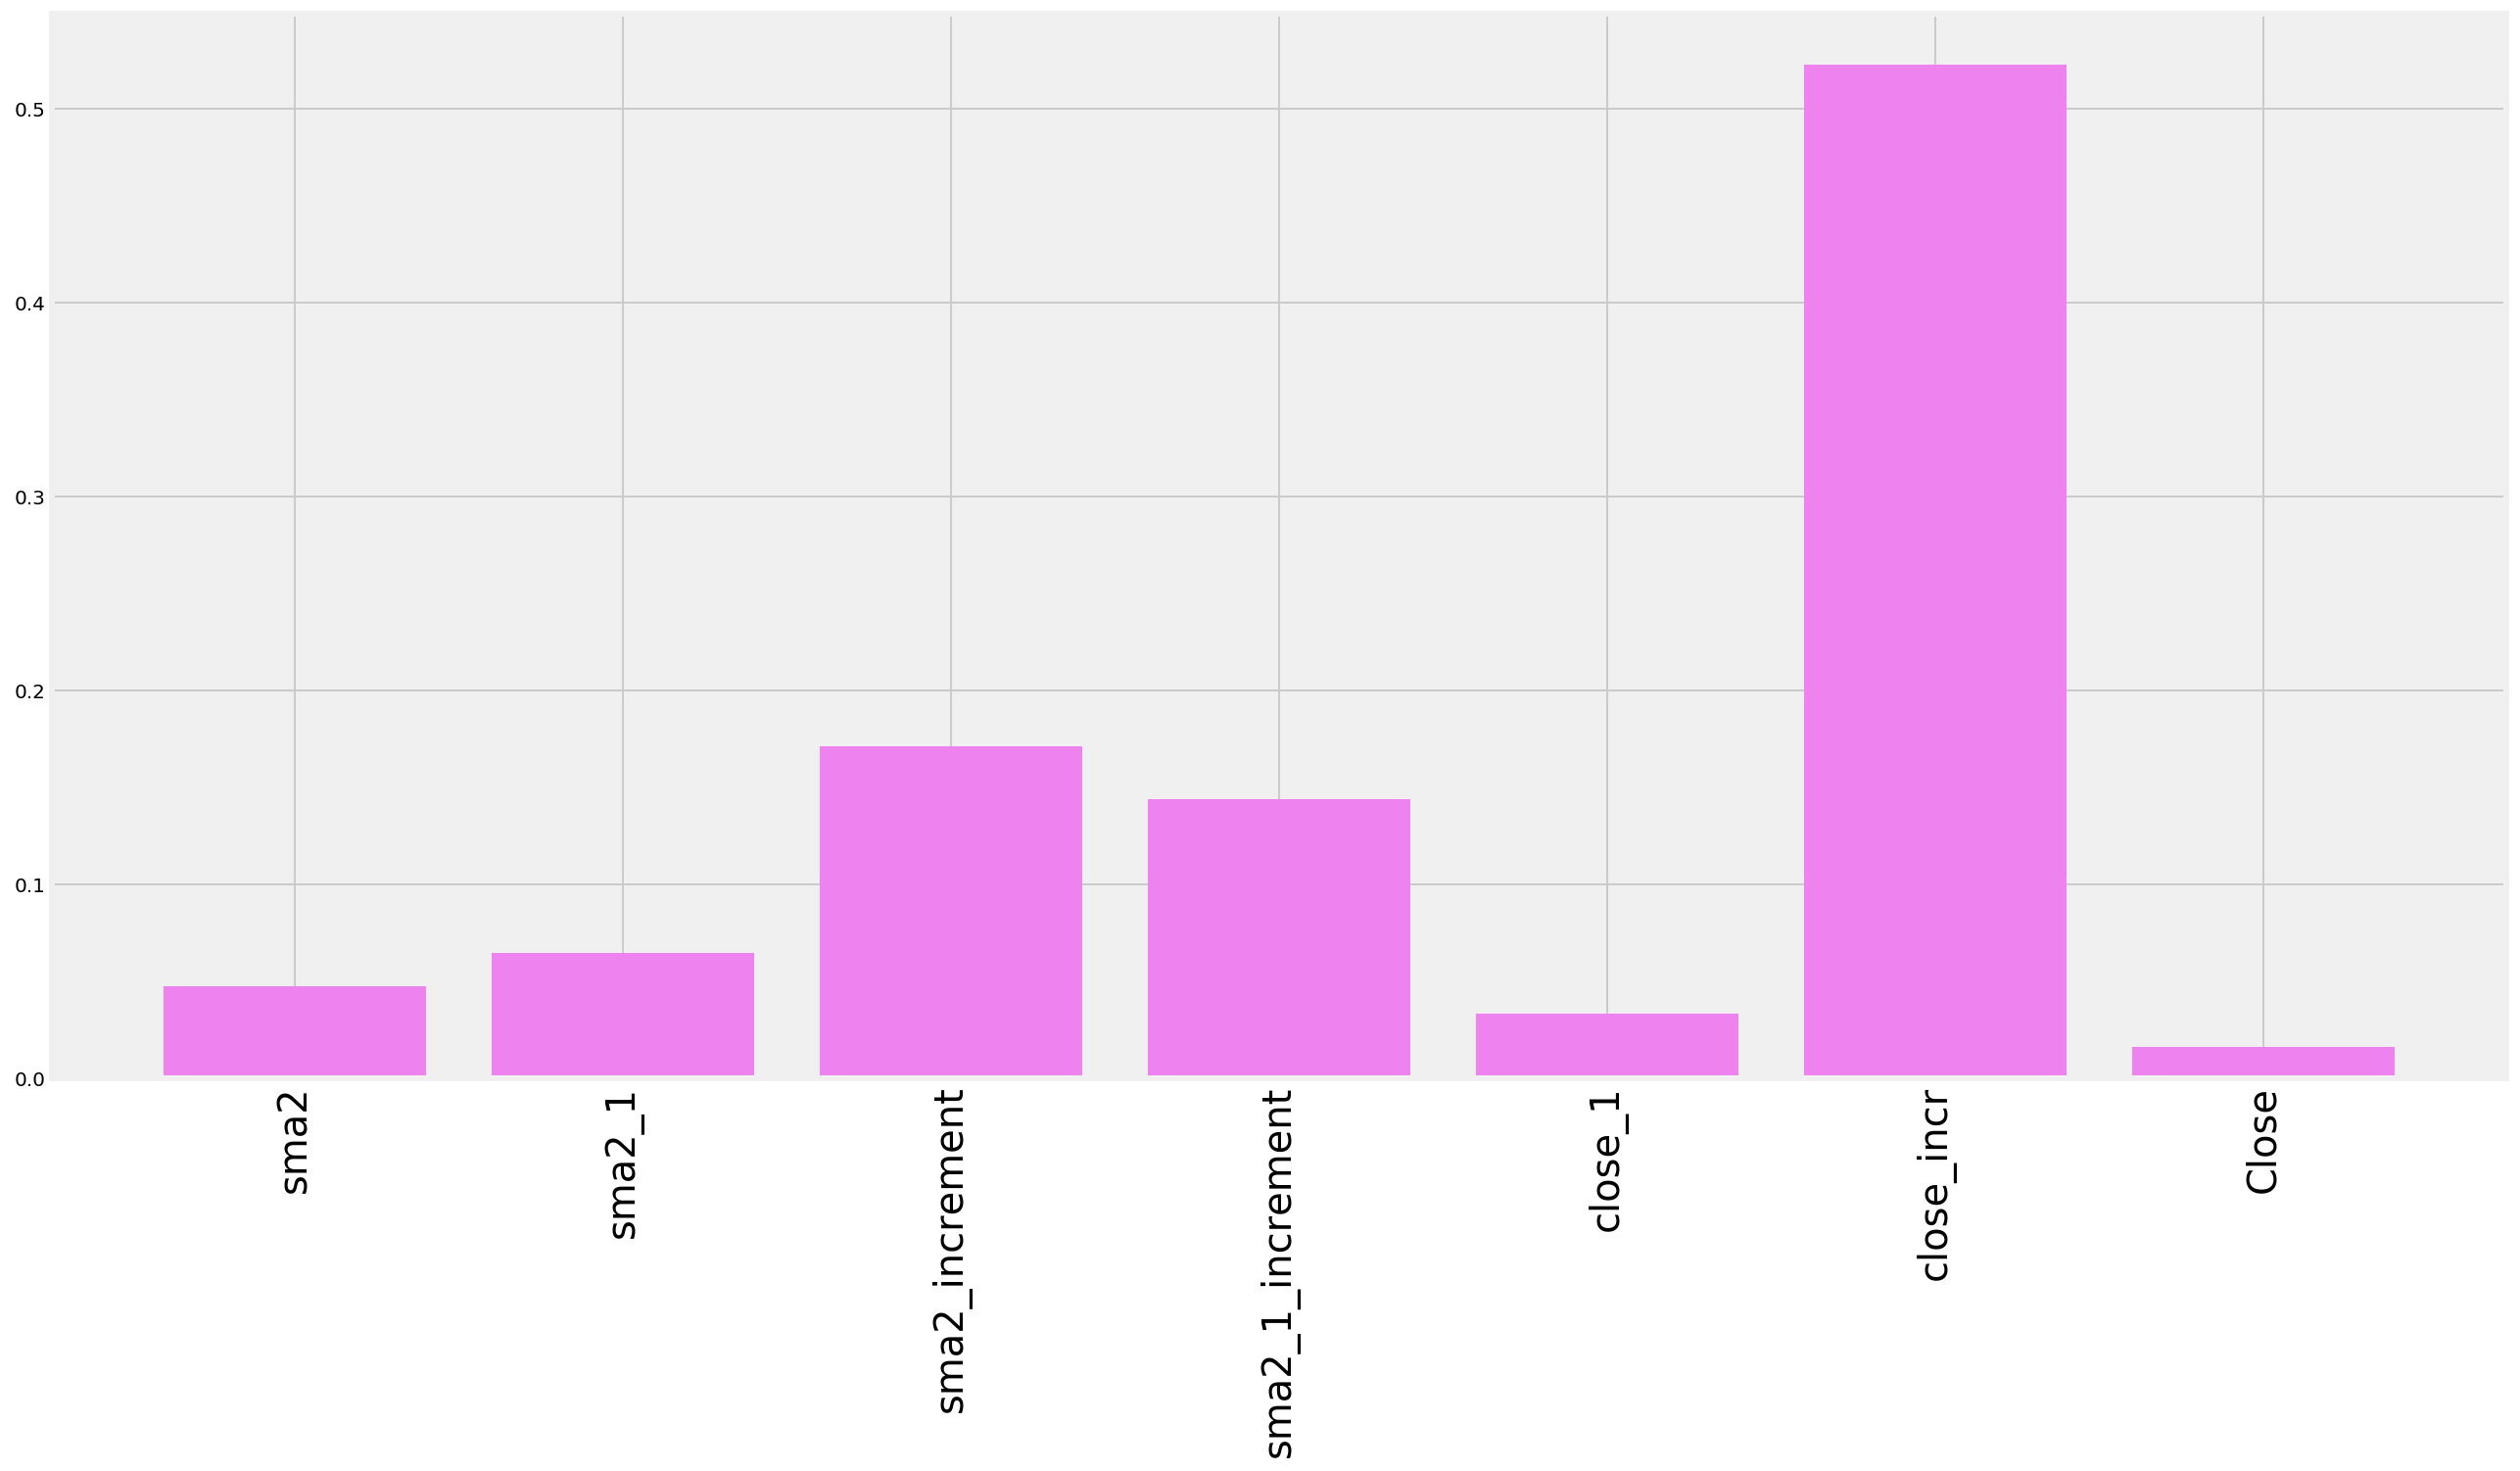

In [724]:
fig = plt.figure(figsize=(20,10))
plt.xticks(rotation='vertical', fontsize=20)
plt.bar([i for i in range(len(xgbModel.feature_importances_))],
        xgbModel.feature_importances_.tolist(), tick_label=X_test.columns, color='Violet')

## Gridsearch over XgBoost Classifier, Attempt

In [358]:
clf = xgb.XGBClassifier()
parameters = {
    'n_estimators': [100, 150, 200],
    'max_depth': [6, 9, 12],
    'subsample': [0.9, 1.0],
    'colsample_bytree': [0.9, 1.0],
}
X, y = X, y
grid = GridSearchCV(clf, parameters, n_jobs=4, 
                   scoring='neg_log_loss',
                   cv=5)
grid.fit(X, y)
print("Best: %f using %s" % (grid.best_score_, grid.best_params_))

means = grid.cv_results_['mean_test_score']
stds = grid.cv_results_['std_test_score']
params = grid.cv_results_['params']

for mean, stdev, param in zip(means, stds, params):
    print("%f (%f) with: %r" % (mean, stdev, param))

/Users/samconnelly/anaconda3/lib/python3.6/site-packages/sklearn/preprocessing/label.py:95: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/Users/samconnelly/anaconda3/lib/python3.6/site-packages/sklearn/preprocessing/label.py:128: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/Users/samconnelly/anaconda3/lib/python3.6/site-packages/sklearn/preprocessing/label.py:95: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/Users/samconnelly/anaconda3/lib/python3.6/site-packages/sklearn/preprocessing/label.py:128: DataConversionWarning: A column-vector y was passed when a 1d a

KeyboardInterrupt: 

In [1188]:
def modelfit(alg, dtrain, predictors, useTrainCV=True, cv_folds=5,
            early_stopping_rounds=50):
    if useTrainCV:
        xgb_param = alg.get_xgb_params()
        xgtrain = xgb.cv(xgb_param, xgtrain, num_boost_round_round=alg.get_params
                        ()['n_estimators'], nfold=cv_folds,
                        metrics='auc', early_stopping_rounds=early_stopping_rounds,
                        show_progress=False)
        alg.set_params(n_estimators=cvresult.shape[0])
        
        #fit the algo
        
        alg.fit(dtrain[predictors], dtrain['Disbursed'],eval_metric='auc')
        
        #predict training set
        dtrain_predictions = alg.predict(dtrain[precictors])
        dtrain_predprob = alg.predict_proba(dtrain[predictors])[:,1]
        
        #print model report:
        print ("\nModel Report")
        print ("Accuracy:"% metrics.accuracy_score(dtrain['Disbursed'].values,
                                                        dtrain_predictions))
        print ("AUC Score (Train):" % metrics.roc_auc_score(dtrain['Disbursed'],
                                                             dtrain_predprob)
        
        xgbModel.feature_importances = pd.Series(alg.booster().get_fscore()).sort_values(ascending=False)
        feat_imp.plot(kind='bar', title='Feature Importances')
        plt.ylabel('Feature Importance Score')

## Neural Network for stock prediction, LVMH  

In [397]:
import random
random.seed(42)

In [398]:
lvmh_nn_df = pd.read_csv('//Users/samconnelly/Desktop/Notebooks_GA/Projects/General-Assembly-Projects/CapStone/MC_.csv')

In [401]:
lvmh_nn_df.columns

Index(['Date_MC', 'Open_MC', 'High_MC', 'Low_MC', 'Close_MC', 'Adj Close_MC',
       'Volume_MC'],
      dtype='object')

In [402]:
lvmh_nn_df['H-L'] = lvmh_nn_df['High_MC'] - lvmh_nn_df['Low_MC']

In [403]:
lvmh_nn_df['C-O'] = lvmh_nn_df['Close_MC'] - lvmh_nn_df['Open_MC']

In [405]:
lvmh_nn_df['3day MA'] = lvmh_nn_df['Close_MC'].shift(1).rolling(window=3).mean()

In [406]:
lvmh_nn_df['10day MA'] = lvmh_nn_df['Close_MC'].shift(1).rolling(window=10).mean()

In [408]:
lvmh_nn_df['30day MA'] = lvmh_nn_df['Close_MC'].shift(1).rolling(window=30).mean()

In [409]:
lvmh_nn_df['Std_dev'] = lvmh_nn_df['Close_MC'].rolling(5).std()

In [410]:
lvmh_nn_df['RSI'] = talib.RSI(lvmh_nn_df['Close_MC'].values, timeperiod=9)

In [414]:
lvmh_nn_df['Williams %R'] = talib.WILLR(lvmh_nn_df['High_MC'].values, lvmh_nn_df['Low_MC'].values,
                                 lvmh_nn_df['Close_MC'].values, 7)

In [415]:
lvmh_nn_df.head()

Date_MC    Open_MC    High_MC     Low_MC   Close_MC  Adj Close_MC  \
0  2002-07-12  45.200001  45.349998  41.500000  42.090000     30.058365   
1  2002-07-15  42.090000  42.910000  39.549999  39.810001     28.430111   
2  2002-07-16  40.680000  41.980000  38.500000  41.250000     29.458488   
3  2002-07-17  40.540001  44.880001  40.540001  43.400002     30.993889   
4  2002-07-18  44.099998  47.110001  43.830002  46.320000     33.079185   

   Volume_MC       H-L       C-O    3day MA  10day MA  30day MA   Std_dev  \
0    2108358  3.849998 -3.110001        NaN       NaN       NaN       NaN   
1    1898886  3.360001 -2.279999        NaN       NaN       NaN       NaN   
2    3333619  3.480000  0.570000        NaN       NaN       NaN       NaN   
3    4192072  4.340000  2.860001  41.050000       NaN       NaN       NaN   
4    3436084  3.279999  2.220002  41.486668       NaN       NaN  2.466866   

   RSI  Williams %R  
0  NaN          NaN  
1  NaN          NaN  
2  NaN          NaN  
3  NaN          NaN  
4  NaN          NaN

In [418]:
lvmh_nn_df['Price_Rise'] = np.where(lvmh_nn_df['Close_MC'].shift(-1)>lvmh_nn_df['Close_MC'], 1, 0)

In [419]:
lvmh_nn_df = lvmh_nn_df.dropna()

In [421]:
X = lvmh_nn_df.iloc[:, 4:-1]
y = lvmh_nn_df.iloc[:, -1]

In [422]:
split = int(len(lvmh_nn_df)*.70)
X_train, X_test, y_train, y_test = X[:split], X[split:], y[:split], y[split:]

In [424]:
sc = StandardScaler()
X_train = sc.fit_transform(X_train)
X_test = sc.transform(X_test)

In [429]:
classifier = Sequential()

classifier.add(Dense(units = 128, kernel_initializer = 'uniform', 
                    activation = 'relu', input_dim = X.shape[1]))
classifier.add(Dense(units = 1, kernel_initializer = 'uniform',
                    activation = 'sigmoid'))
classifier.compile(optimizer = 'adam', loss = 'mean_squared_error',
                  metrics = ['accuracy'])

classifier.fit(X_train, y_train, batch_size = 10, epochs = 100)

Epoch 1/100
2852/2852 [==============================] - 1s 315us/step - loss: 0.2503 - acc: 0.4975
Epoch 2/100
2852/2852 [==============================] - 1s 248us/step - loss: 0.2495 - acc: 0.5263
Epoch 3/100
2852/2852 [==============================] - 1s 257us/step - loss: 0.2494 - acc: 0.5126
Epoch 4/100
2852/2852 [==============================] - 1s 215us/step - loss: 0.2489 - acc: 0.5210
Epoch 5/100
2852/2852 [==============================] - 1s 209us/step - loss: 0.2488 - acc: 0.5270
Epoch 6/100
2852/2852 [==============================] - 1s 220us/step - loss: 0.2487 - acc: 0.5295
Epoch 7/100
2852/2852 [==============================] - 1s 234us/step - loss: 0.2486 - acc: 0.5252
Epoch 8/100
2852/2852 [==============================] - 1s 221us/step - loss: 0.2484 - acc: 0.5347
Epoch 9/100
2852/2852 [==============================] - 1s 240us/step - loss: 0.2487 - acc: 0.5291
Epoch 10/100
2852/2852 [==============================] - 1s 211us/step - loss: 0.2482 - acc: 0.5263

2852/2852 [==============================] - 1s 255us/step - loss: 0.2393 - acc: 0.5838
Epoch 83/100
2852/2852 [==============================] - 1s 260us/step - loss: 0.2388 - acc: 0.5852
Epoch 84/100
2852/2852 [==============================] - 1s 292us/step - loss: 0.2384 - acc: 0.5905
Epoch 85/100
2852/2852 [==============================] - 1s 277us/step - loss: 0.2383 - acc: 0.5813
Epoch 86/100
2852/2852 [==============================] - 1s 264us/step - loss: 0.2375 - acc: 0.5936
Epoch 87/100
2852/2852 [==============================] - 1s 270us/step - loss: 0.2381 - acc: 0.5859
Epoch 88/100
2852/2852 [==============================] - 1s 229us/step - loss: 0.2386 - acc: 0.5908
Epoch 89/100
2852/2852 [==============================] - 1s 283us/step - loss: 0.2375 - acc: 0.5936
Epoch 90/100
2852/2852 [==============================] - 1s 260us/step - loss: 0.2377 - acc: 0.5852
Epoch 91/100
2852/2852 [==============================] - 1s 253us/step - loss: 0.2378 - acc: 0.5954
Epo

In [430]:
y_pred = classifier.predict(X_test)
y_pred = (y_pred > 0.5)

In [433]:
lvmh_nn_df['y_pred'] = np.NaN
lvmh_nn_df.iloc[(len(lvmh_nn_df) - len(y_pred)):,-1:] = y_pred
trade_lvmh = lvmh_nn_df.dropna()

In [ ]:
trade_lvmh['Tomorrows Return'] = 0
trade_lvmh[]

## Neural Net with abrided closing number indicators rd 2

In [676]:
from keras.models import Sequential
from sklearn.pipeline import Pipeline
from keras.layers import Dense, Dropout
from keras.utils import to_categorical
from keras.callbacks import EarlyStopping
from keras import regularizers
from keras.wrappers.scikit_learn import KerasClassifier
from numpy.random import seed
seed(1)
from tensorflow import set_random_seed
set_random_seed(2)

def keras_gridsearch(hidden_layer_one=33, hidden_layer_two=16):
    model = Sequential()
    model.add(Dense(33, activation='relu', input_dim=X_train.shape[1], kernel_regularizer=regularizers.l2(0.001))) 
    model.add(Dense(hidden_layer_one, activation='relu', kernel_regularizer=regularizers.l2(0.001))) 
    model.add(Dropout(.25))
    model.add(Dense(hidden_layer_two, activation='relu', kernel_regularizer=regularizers.l2(0.001)))
    model.add(Dropout(.25))
    model.add(Dense(1, activation='sigmoid')) 
    model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])
    return model

In [677]:
X = lvmh_nn_df.iloc[:, 4:-1]
y = lvmh_nn_df.iloc[:, -1]

In [678]:
split = int(len(lvmh_nn_df)*.70)
X_train, X_test, y_train, y_test = X[:split], X[split:], y[:split], y[split:]

In [679]:
ss_nn = StandardScaler()
keras = KerasClassifier(build_fn=keras_gridsearch, verbose=1)

pipe = Pipeline([
    ('ss', ss_nn),
    ('keras', keras)])

In [681]:
params = {
    'keras__epochs': [100],
    'keras__batch_size': [32],
    'keras__hidden_layer_one': [30],
    'keras__hidden_layer_two': [20]
}

gs = GridSearchCV(pipe, params, verbose=1, cv=2)
gs.fit(X_train, y_train)
print(gs.best_score_)
print(gs.best_params_)

Fitting 2 folds for each of 1 candidates, totalling 2 fits
Epoch 1/100
1426/1426 [==============================] - 1s 512us/step - loss: 0.4737 - acc: 0.8990
Epoch 2/100
1426/1426 [==============================] - 0s 173us/step - loss: 0.1481 - acc: 1.0000
Epoch 3/100
1426/1426 [==============================] - 0s 210us/step - loss: 0.0839 - acc: 0.9993
Epoch 4/100
1426/1426 [==============================] - 0s 159us/step - loss: 0.0710 - acc: 1.0000
Epoch 5/100
1426/1426 [==============================] - 0s 122us/step - loss: 0.0647 - acc: 1.0000
Epoch 6/100
1426/1426 [==============================] - 0s 128us/step - loss: 0.0603 - acc: 1.0000
Epoch 7/100
1426/1426 [==============================] - 0s 126us/step - loss: 0.0563 - acc: 1.0000
Epoch 8/100
1426/1426 [==============================] - 0s 166us/step - loss: 0.0532 - acc: 1.0000
Epoch 9/100
1426/1426 [==============================] - 0s 174us/step - loss: 0.0498 - acc: 1.0000
Epoch 10/100
1426/1426 [=================

1426/1426 [==============================] - 0s 167us/step - loss: 0.0020 - acc: 1.0000
Epoch 82/100
1426/1426 [==============================] - 0s 175us/step - loss: 0.0018 - acc: 1.0000
Epoch 83/100
1426/1426 [==============================] - 0s 149us/step - loss: 0.0018 - acc: 1.0000
Epoch 84/100
1426/1426 [==============================] - 0s 171us/step - loss: 0.0016 - acc: 1.0000
Epoch 85/100
1426/1426 [==============================] - 0s 142us/step - loss: 0.0016 - acc: 1.0000
Epoch 86/100
1426/1426 [==============================] - 0s 133us/step - loss: 0.0016 - acc: 1.0000
Epoch 87/100
1426/1426 [==============================] - 0s 186us/step - loss: 0.0015 - acc: 1.0000
Epoch 88/100
1426/1426 [==============================] - 0s 171us/step - loss: 0.0015 - acc: 1.0000
Epoch 89/100
1426/1426 [==============================] - 0s 161us/step - loss: 0.0015 - acc: 1.0000
Epoch 90/100
1426/1426 [==============================] - 0s 177us/step - loss: 0.0014 - acc: 1.0000
Epo

1426/1426 [==============================] - 0s 217us/step - loss: 0.0025 - acc: 1.0000
Epoch 62/100
1426/1426 [==============================] - 0s 249us/step - loss: 0.0024 - acc: 1.0000
Epoch 63/100
1426/1426 [==============================] - 0s 222us/step - loss: 0.0022 - acc: 1.0000
Epoch 64/100
1426/1426 [==============================] - 0s 202us/step - loss: 0.0022 - acc: 1.0000
Epoch 65/100
1426/1426 [==============================] - 0s 192us/step - loss: 0.0022 - acc: 1.0000
Epoch 66/100
1426/1426 [==============================] - 0s 215us/step - loss: 0.0021 - acc: 1.0000
Epoch 67/100
1426/1426 [==============================] - 0s 206us/step - loss: 0.0019 - acc: 1.0000
Epoch 68/100
1426/1426 [==============================] - 0s 211us/step - loss: 0.0018 - acc: 1.0000
Epoch 69/100
1426/1426 [==============================] - 0s 218us/step - loss: 0.0018 - acc: 1.0000
Epoch 70/100
1426/1426 [==============================] - 0s 197us/step - loss: 0.0017 - acc: 1.0000
Epo

[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:   53.8s finished


Epoch 1/100
2852/2852 [==============================] - 1s 402us/step - loss: 0.2734 - acc: 0.9646
Epoch 2/100
2852/2852 [==============================] - 1s 209us/step - loss: 0.0788 - acc: 1.0000
Epoch 3/100
2852/2852 [==============================] - 1s 205us/step - loss: 0.0677 - acc: 1.0000
Epoch 4/100
2852/2852 [==============================] - 1s 210us/step - loss: 0.0593 - acc: 1.0000
Epoch 5/100
2852/2852 [==============================] - 1s 215us/step - loss: 0.0522 - acc: 1.0000
Epoch 6/100
2852/2852 [==============================] - 1s 230us/step - loss: 0.0458 - acc: 1.0000
Epoch 7/100
2852/2852 [==============================] - 1s 206us/step - loss: 0.0402 - acc: 1.0000
Epoch 8/100
2852/2852 [==============================] - 1s 215us/step - loss: 0.0355 - acc: 1.0000
Epoch 9/100
2852/2852 [==============================] - 1s 237us/step - loss: 0.0312 - acc: 1.0000
Epoch 10/100
2852/2852 [==============================] - 1s 198us/step - loss: 0.0273 - acc: 1.0000

2852/2852 [==============================] - 1s 184us/step - loss: 1.8212e-04 - acc: 1.0000
Epoch 81/100
2852/2852 [==============================] - 1s 190us/step - loss: 1.6033e-04 - acc: 1.0000
Epoch 82/100
2852/2852 [==============================] - 1s 185us/step - loss: 1.3454e-04 - acc: 1.0000
Epoch 83/100
2852/2852 [==============================] - 1s 176us/step - loss: 1.4837e-04 - acc: 1.0000
Epoch 84/100
2852/2852 [==============================] - 1s 193us/step - loss: 1.5287e-04 - acc: 1.0000
Epoch 85/100
2852/2852 [==============================] - 0s 172us/step - loss: 1.1309e-04 - acc: 1.0000
Epoch 86/100
2852/2852 [==============================] - 0s 172us/step - loss: 1.0744e-04 - acc: 1.0000
Epoch 87/100
2852/2852 [==============================] - 1s 177us/step - loss: 1.1849e-04 - acc: 1.0000
Epoch 88/100
2852/2852 [==============================] - 0s 162us/step - loss: 1.0473e-04 - acc: 1.0000
Epoch 89/100
2852/2852 [==============================] - 0s 162us/s

## Neural Net with abridged closing number indicators

In [660]:
import random
random.seed(42)

In [661]:
lvmh_nn_close = Predictors.copy()

In [662]:
lvmh_nn_close.head(0)

Empty DataFrame
Columns: [sma2, sma2_1, sma2_increment, sma2_1_increment, close_1, close_incr, Close]
Index: []

In [663]:
lvmh_nn_close['Price_Rise'] = np.where(lvmh_nn_close['Close'].shift(-1)>lvmh_nn_close['Close'], 1, 0)

In [664]:
lvmh_nn_close.isnull().sum()

sma2                0
sma2_1              0
sma2_increment      0
sma2_1_increment    0
close_1             0
close_incr          0
Close               0
Price_Rise          0
dtype: int64

In [665]:
X = lvmh_nn_close.iloc[:, 4:-1]
y = lvmh_nn_close.iloc[:, -1]

In [666]:
split = int(len(lvmh_nn_close)*.70)
X_train, X_test, y_train, y_test = X[:split], X[split:], y[:split], y[split:]

In [667]:
sc = StandardScaler()
X_train = sc.fit_transform(X_train)
X_test = sc.transform(X_test)

In [668]:
classifier = Sequential()

classifier.add(Dense(units = 128, kernel_initializer = 'uniform', 
                    activation = 'relu', input_dim = X.shape[1]))
classifier.add(Dense(units = 1, kernel_initializer = 'uniform',
                    activation = 'sigmoid'))
classifier.compile(optimizer = 'adam', loss = 'mean_squared_error',
                  metrics = ['accuracy'])

classifier.fit(X_train, y_train, batch_size = 30, epochs = 100)

Epoch 1/100
2793/2793 [==============================] - 0s 168us/step - loss: 0.2503 - acc: 0.4787
Epoch 2/100
2793/2793 [==============================] - 0s 100us/step - loss: 0.2500 - acc: 0.5077
Epoch 3/100
2793/2793 [==============================] - 0s 81us/step - loss: 0.2500 - acc: 0.5073
Epoch 4/100
2793/2793 [==============================] - 0s 73us/step - loss: 0.2499 - acc: 0.5052
Epoch 5/100
2793/2793 [==============================] - 0s 75us/step - loss: 0.2500 - acc: 0.5077
Epoch 6/100
2793/2793 [==============================] - 0s 71us/step - loss: 0.2499 - acc: 0.5084
Epoch 7/100
2793/2793 [==============================] - 0s 66us/step - loss: 0.2499 - acc: 0.5091
Epoch 8/100
2793/2793 [==============================] - 0s 74us/step - loss: 0.2499 - acc: 0.5109
Epoch 9/100
2793/2793 [==============================] - 0s 97us/step - loss: 0.2499 - acc: 0.5124
Epoch 10/100
2793/2793 [==============================] - 0s 86us/step - loss: 0.2499 - acc: 0.5073
Epoch 1

2793/2793 [==============================] - 0s 69us/step - loss: 0.2496 - acc: 0.5242
Epoch 83/100
2793/2793 [==============================] - 0s 82us/step - loss: 0.2494 - acc: 0.5242
Epoch 84/100
2793/2793 [==============================] - 0s 97us/step - loss: 0.2494 - acc: 0.5224
Epoch 85/100
2793/2793 [==============================] - 0s 74us/step - loss: 0.2494 - acc: 0.5174
Epoch 86/100
2793/2793 [==============================] - 0s 98us/step - loss: 0.2494 - acc: 0.5249
Epoch 87/100
2793/2793 [==============================] - 0s 97us/step - loss: 0.2494 - acc: 0.5188
Epoch 88/100
2793/2793 [==============================] - 0s 82us/step - loss: 0.2494 - acc: 0.5202
Epoch 89/100
2793/2793 [==============================] - 0s 81us/step - loss: 0.2494 - acc: 0.5213
Epoch 90/100
2793/2793 [==============================] - 0s 89us/step - loss: 0.2494 - acc: 0.5220
Epoch 91/100
2793/2793 [==============================] - 0s 90us/step - loss: 0.2494 - acc: 0.5260
Epoch 92/100


## Pipeline for stock predictions

stocks: Burberry, LVMH, Kering, PVH, Nike, Puma, Adidas

Models: Random Forest Classifier(rf), Logistic Regression(lr), XgBoost Classifier(xgb), Support Vector Machine(svm)

Baseline model score: .52

In [1193]:
def df_builder(stock):
    predictors = pd.DataFrame(closeprice_etf['Close_'+stock])
    predictors.columns = ['Close']
    predictors['sma2'] = predictors['Close'].rolling(window=2).mean()
    predictors["sma2_1"] = predictors.sma2.shift(1)
    predictors['sma2_increment'] = predictors.sma2.diff()
    predictors['sma2_1_increment'] = predictors.sma2_1.diff()
    predictors['close_1'] = predictors['Close'].shift(1)
    predictors['close_incr'] = predictors['Close'] - predictors['Close'].shift(1)
    predictors['target'] = predictors['close_incr']>0
    predictors = predictors.dropna()
    return predictors

In [1194]:
def trainer_tester(df):
    y = df['target']
    x = df.drop(['target', 'close_incr'], axis=1)
    ## make 70% training set, 30% test set
    training_indicies = int(df.shape[0]*.7)
    x_train = x.iloc[:training_indicies]
    y_train = y.iloc[:training_indicies]
    x_test = x.iloc[training_indicies:]
    y_test = y.iloc[training_indicies:]
    return [x_train, y_train, x_test, y_test]

In [1195]:
def run_model(x_train, y_train, x_test, y_test, model):
    model.fit(x_train, y_train)
    print(j)
    if i == rf:
        print("Random Forest")
    if i == lr:
        print("Logistic Regression")
    if i == svm:
        print("Support Vector Machine")
    if i == xgb:
        print("XgBoost")
    print("Training Score: {}".format(model.score(x_train, y_train)))
    print("Test Score: {}".format(model.score(x_test,y_test)))
    print("Confusion Matrix: {}".format(confusion_matrix(y_test_binary, y_predicted_binary)))
    print("Classification_report: {}".format(classification_report(y_test_binary, y_predicted_binary)))
    #accuracy
    #feature importance
    #classification report
    #confusion matrix
    #model.predict(x_test)

In [1196]:
def pipeline(stock, model):
    data = trainer_tester(df_builder(stock))
    run_model(data[0], data[1], data[2], data[3], model)

In [1197]:
rf = RandomForestClassifier()
lr = LogisticRegression()
svm = SVC()
xgb = XGBClassifier()

models = [rf, lr, svm, xgb]
model_names = ['rf', 'lr', 'svm', 'xgb']
stocks = ['BRBY', 'MC','KER', 'PVH', 'NKE', 'PUM', 'ADS']

In [1198]:
for i in models:
    for j in stocks:
        pipeline(j, i)

BRBY
Random Forest
Training Score: 0.9881847475832438
Test Score: 0.7101086048454469
Confusion Matrix: [[489  82]
 [237 389]]
Classification_report:              precision    recall  f1-score   support

          0       0.67      0.86      0.75       571
          1       0.83      0.62      0.71       626

avg / total       0.75      0.73      0.73      1197

MC
Random Forest
Training Score: 0.9860365198711063
Test Score: 0.6382623224728488
Confusion Matrix: [[489  82]
 [237 389]]
Classification_report:              precision    recall  f1-score   support

          0       0.67      0.86      0.75       571
          1       0.83      0.62      0.71       626

avg / total       0.75      0.73      0.73      1197

KER
Random Forest
Training Score: 0.9881847475832438
Test Score: 0.7426900584795322
Confusion Matrix: [[489  82]
 [237 389]]
Classification_report:              precision    recall  f1-score   support

          0       0.67      0.86      0.75       571
          1       0

/Users/samconnelly/anaconda3/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/Users/samconnelly/anaconda3/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/Users/samconnelly/anaconda3/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/Users/samconnelly/anaconda3/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth valu

KER
XgBoost
Training Score: 0.8424633011099176
Test Score: 0.7786131996658312
Confusion Matrix: [[489  82]
 [237 389]]
Classification_report:              precision    recall  f1-score   support

          0       0.67      0.86      0.75       571
          1       0.83      0.62      0.71       626

avg / total       0.75      0.73      0.73      1197

PVH
XgBoost
Training Score: 0.8363766559255281
Test Score: 0.7852965747702589
Confusion Matrix: [[489  82]
 [237 389]]
Classification_report:              precision    recall  f1-score   support

          0       0.67      0.86      0.75       571
          1       0.83      0.62      0.71       626

avg / total       0.75      0.73      0.73      1197



/Users/samconnelly/anaconda3/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/Users/samconnelly/anaconda3/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/Users/samconnelly/anaconda3/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/Users/samconnelly/anaconda3/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth valu

NKE
XgBoost
Training Score: 0.8360186179735052
Test Score: 0.7852965747702589
Confusion Matrix: [[489  82]
 [237 389]]
Classification_report:              precision    recall  f1-score   support

          0       0.67      0.86      0.75       571
          1       0.83      0.62      0.71       626

avg / total       0.75      0.73      0.73      1197

PUM
XgBoost
Training Score: 0.8474758324382384
Test Score: 0.7919799498746867
Confusion Matrix: [[489  82]
 [237 389]]
Classification_report:              precision    recall  f1-score   support

          0       0.67      0.86      0.75       571
          1       0.83      0.62      0.71       626

avg / total       0.75      0.73      0.73      1197



/Users/samconnelly/anaconda3/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/Users/samconnelly/anaconda3/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/Users/samconnelly/anaconda3/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/Users/samconnelly/anaconda3/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth valu

ADS
XgBoost
Training Score: 0.8270676691729323
Test Score: 0.8220551378446115
Confusion Matrix: [[489  82]
 [237 389]]
Classification_report:              precision    recall  f1-score   support

          0       0.67      0.86      0.75       571
          1       0.83      0.62      0.71       626

avg / total       0.75      0.73      0.73      1197



/Users/samconnelly/anaconda3/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/Users/samconnelly/anaconda3/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:


##### Attempts and Pseudocode at developing a pipeline 

In [ ]:
model_type = [svm, xgb, rf]
svm = svm.SVC(kernel='linear', C=1, gamma=1)
clf = RandomForestClassifier(bootstrap=True, criterion='gini', max_depth=2, random_state=0)
xgb = XGBClassifier(gamma=0.15, n_estimators=150, base_score=.70, colsample_bytree=.8,learning_rate=0.3)

#modeling function
#list of models
for i in list of models:
    run model(i)

def modeler(model_type, X_train, X_test, y_train, y_test):
    for i in list of models:
        model = i.fit(X_train, y_train.Value.apply(getBinary))
        y_predicted_i = i.predict(X_test)
        y_predicted_binary_i = [1 if yp>=0.5 else 0 for yp in y_predicted_i]
        print(accuracy_score(y_test_binary, y_predicted_binary_i))
        print(i.feature_importances_)
        print(classification_report(y_test_binary, y_predicted_i))  

In [972]:
def stock_modeler(stock_df, model_type):
    for col in closeprice_etf:
        stock_df +'pred_close' = closeprice_etf['Close_stock_df' stock_df]
        stock_df +'pred_close' = stock_df+'pred_close'.to_frame()
        predictors = pd.DataFrame({"sma2":stock_df +'pred_close'['Close_stock_df'].rolling(window=2).mean()})
        predictors["sma2_1"] = predictors.sma2.shift(1)
        predictors['sma2_increment'] = predictors.sma2.diff()
        predictors['sma2_1_increment'] = predictors.sma2_1.diff()
        predictors['close_1'] = stock_df +'pred_close'['Close_stock_df].shift(1)
        predictors['close_incr'] = stock_df +'pred_close'['Close_stock_df'] - stock_df +'pred_close'['Close_stock_df'].shift(1)
        predictors['close'] = stock_df +'pred_close'['Close_stock_df']
        predictors = predictors.dropna()
        target_rf = pd.DataFrame({'Value':predictors.sma2.shift(-1) - predictors.sma2}).dropna()
        X = pd.merge(predictors, target,left_index=True,right_index=True)[predictors.columns]
        y = pd.merge(predictors, target,left_index=True,right_index=True)[target.columns]
        train_samples = int(X.shape[0] * 0.70)
        X_train = X.iloc[:train_samples]
        X_test = X.iloc[train_samples:]
        y_train = y.iloc[:train_samples]
        y_test = y.iloc[train_samples:]

    def getBinary(val):
        if val>0:
            return 1
        else:
            return 0
    
    y_test_binary = pd.DataFrame(y_test['Value'].apply(getBinary))                                              
    
    for model_type if model_type = svm:
            svm = svm.SVC(kernel='linear', C=1, gamma=1)
            svmmodel = svm.fit(X_train, y_train.Value.apply(getBinary))
            y_predicted_svm = svmmodel.predict(X_test)
            y_predicted_binary_svm = [1 if yp >=0.5 else 0 for yp in y_predicted_svm]                                           
                   if model_type = clf:
            clf = RandomForestClassifier(bootstrap=True, criterion='gini', max_depth=2, random_state=0)
            rfmodel = clf.fit(X_train, y_train.Value.apply(getBinary))
            y_predicted_rf = rfmodel.predict(X_test)
            y_predicted_binary = [1 if yp >=0.5 else 0 for yp in y_predicted_rf]
                   if model_type = xgb:
            xgb = XGBClassifier(gamma=0.15, n_estimators=150, base_score=.70, colsample_bytree=.8,learning_rate=0.3)                                 
            xgbmodel = xgb.fit(X_train, y_train.Value.apply(getBinary))
            y_predicted_xgb = xgbmodel.predict(X_test)
            y_predicted_binary_xgb = [1 if yp >=0.5 else 0 for yp in y_predicted_xgb]
    for stock_df:
            print(accuracy_score(y_test_binary, y_predicted_binary_model_type))
            print(model_type.feature_importances_)
            print(classification_report(y_test_binary, y_predicted_binary_model_type))

                                                 
    

#loads in the larger closing_etf df
#Cuts out the necessary closing price 
#creates all of these indicator features
## lvmh_stockpred_df = lvmh_stockpred_df.to_frame()
## nke_pred_close = nke_pred_close.to_frame()
## Predictors = pd.DataFrame({"sma2":lvmh_stockpred_df['Close_MC'].rolling(window=2).mean()})
## Predictors["sma2_1"] = Predictors.sma2.shift(1)
## Predictors['sma2_increment'] = Predictors.sma2.diff()
## Predictors['sma2_1_increment'] = Predictors.sma2_1.diff()
## Predictors['close_1'] = lvmh_stockpred_df['Close_MC'].shift(1)
## Predictors['close_incr'] = lvmh_stockpred_df['Close_MC'] - lvmh_stockpred_df['Close_MC'].shift(1)
## Predictors['Close'] = lvmh_stockpred_df['Close_MC']
## Predictors = Predictors.dropna()
# Set X and Y
# Set up training and test sets
# Performs binary conversion function
# Y test binary
# set model params
# Fit models on those param
# Run predictions
# Score model
# Score features
# Model Summary

## Predictions for each stock run over rf, xgb and svm

##### LVMH

In [947]:
X = pd.merge(Predictors, target,left_index=True,right_index=True)[Predictors.columns]
y = pd.merge(Predictors, target,left_index=True,right_index=True)[target.columns]

train_samples = int(X.shape[0] * 0.70)

X_train = X.iloc[:train_samples]
X_test = X.iloc[train_samples:]

y_train = y.iloc[:train_samples]
y_test = y.iloc[train_samples:]

def getBinary(val):
    if val>0:
        return 1
    else:
        return 0
    
y_test_binary = pd.DataFrame(y_test['Value'].apply(getBinary))

In [948]:
from sklearn import svm
from sklearn.svm import SVC

clf = RandomForestClassifier(bootstrap=True, criterion='gini', max_depth=2, random_state=0)
svm = svm.SVC(kernel='linear', C=1, gamma=1)
xgb = XGBClassifier(gamma=0.15, n_estimators=150, base_score=.70, colsample_bytree=.8,learning_rate=0.3)


rfmodel = clf.fit(X_train, y_train.Value.apply(getBinary))
svmmodel = svm.fit(X_train, y_train.Value.apply(getBinary))
xgbmodel = xgb.fit(X_train, y_train.Value.apply(getBinary))

y_predicted = rfmodel.predict(X_test)
y_predicted_svm = svmmodel.predict(X_test)
y_predicted_xgb = xgbmodel.predict(X_test)
y_predicted_binary = [1 if yp >=0.5 else 0 for yp in y_predicted]
y_predicted_binary_svm = [1 if yp >=0.5 else 0 for yp in y_predicted_svm]
y_predicted_binary_xgb = [1 if yp >=0.5 else 0 for yp in y_predicted_xgb]

print('Accuracy Scores\n')
print('Random Forest:')
print(accuracy_score(y_test_binary, y_predicted_binary))

print('Support Vector Machine:')
print(accuracy_score(y_test_binary, y_predicted_binary_svm))

print('XgBoost:')
print(accuracy_score(y_test_binary, y_predicted_binary_xgb))


print('\nFeature Importances\n')
print('RF Features:')
print(clf.feature_importances_)

print('XgBoost Features:')
print(xgb.feature_importances_)

print('\nClassification Reports\n')
print('RF Report:')
print(classification_report(y_test_binary, y_predicted_binary))

print('\nSVM Report:')
print(classification_report(y_test_binary, y_predicted_binary_svm))

print('\nXgBoost Report:')
print(classification_report(y_test_binary, y_predicted_binary_xgb))

Accuracy Scores

Random Forest:
0.733500417710944
Support Vector Machine:
0.746031746031746
XgBoost:
0.6791979949874687

Feature Importances

RF Features:
[0.00554886 0.08442715 0.19444232 0.07933449 0.08883697 0.49346264
 0.05394757]
XgBoost Features:
[0.10905126 0.1221374  0.17666303 0.22028354 0.087241   0.1821156
 0.10250818]

Classification Reports

RF Report:
             precision    recall  f1-score   support

          0       0.67      0.86      0.75       571
          1       0.83      0.62      0.71       626

avg / total       0.75      0.73      0.73      1197


SVM Report:
             precision    recall  f1-score   support

          0       0.74      0.73      0.73       571
          1       0.75      0.77      0.76       626

avg / total       0.75      0.75      0.75      1197


XgBoost Report:
             precision    recall  f1-score   support

          0       0.62      0.82      0.71       571
          1       0.77      0.55      0.64       626

avg / total

/Users/samconnelly/anaconda3/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:


In [905]:
clf = RandomForestClassifier(bootstrap=True, criterion='gini', max_depth=2, random_state=0)

rfmodel = clf.fit(X_train, y_train.Value.apply(getBinary))

y_predicted = rfmodel.predict(X_test)
y_predicted_binary = [1 if yp >=0.5 else 0 for yp in y_predicted]

print('Accuracy Score:\n')
print(accuracy_score(y_test_binary, y_predicted_binary))

print('\nFeature Importances:\n')
print(clf.feature_importances_)

print('\nClassiciation Report:\n')
print(classification_report(y_test_binary, y_predicted_binary))

Accuracy Score:

0.733500417710944

Feature Importances:

[0.00554886 0.08442715 0.19444232 0.07933449 0.08883697 0.49346264
 0.05394757]

Classiciation Report:

             precision    recall  f1-score   support

          0       0.67      0.86      0.75       571
          1       0.83      0.62      0.71       626

avg / total       0.75      0.73      0.73      1197



## Kering

In [758]:
kering_pred_close = closeprice_etf['Close_KER']

In [759]:
kering_pred_close.head()

2002-07-12    82.255798
2002-07-15    73.472504
2002-07-16    74.030197
2002-07-17    77.562103
2002-07-18    84.579399
Name: Close_KER, dtype: float64

In [763]:
type(kering_pred_close)

pandas.core.frame.DataFrame

In [764]:
ker_predictors = pd.DataFrame({"sma2":kering_pred_close['Close_KER'].rolling(window=2).mean()})
ker_predictors["sma2_1"] = ker_predictors.sma2.shift(1)
ker_predictors['sma2_increment'] = ker_predictors.sma2.diff()
ker_predictors['sma2_1_increment'] = ker_predictors.sma2_1.diff()
ker_predictors['close_1'] = kering_pred_close['Close_KER'].shift(1)
ker_predictors['close_incr'] = kering_pred_close['Close_KER'] - kering_pred_close['Close_KER'].shift(1)
ker_predictors['Close'] = kering_pred_close['Close_KER']
ker_predictors = ker_predictors.dropna()
ker_predictors.head()

sma2     sma2_1  sma2_increment  sma2_1_increment    close_1  \
2002-07-17  75.796150  73.751350        2.044799         -4.112801  74.030197   
2002-07-18  81.070751  75.796150        5.274601          2.044799  77.562103   
2002-07-19  82.952850  81.070751        1.882099          5.274601  84.579399   
2002-07-22  81.279850  82.952850       -1.673001          1.882099  81.326302   
2002-07-23  79.026001  81.279850       -2.253849         -1.673001  81.233398   

            close_incr      Close  
2002-07-17    3.531906  77.562103  
2002-07-18    7.017296  84.579399  
2002-07-19   -3.253097  81.326302  
2002-07-22   -0.092904  81.233398  
2002-07-23   -4.414794  76.818604

In [765]:
target_ker_rf = pd.DataFrame({'Value':ker_predictors.sma2.shift(-1) - ker_predictors.sma2}).dropna()

In [907]:
X = pd.merge(ker_predictors, target,left_index=True,right_index=True)[ker_predictors.columns]
y = pd.merge(ker_predictors, target,left_index=True,right_index=True)[target_ker_rf.columns]

train_samples = int(X.shape[0] * 0.70)

X_train = X.iloc[:train_samples]
X_test = X.iloc[train_samples:]

y_train = y.iloc[:train_samples]
y_test = y.iloc[train_samples:]

def getBinary(val):
    if val>0:
        return 1
    else:
        return 0
    
y_test_binary = pd.DataFrame(y_test['Value'].apply(getBinary))

In [ ]:
classifier = XGBClassifier(gamma=0.15, n_estimators=150, base_score=.70, colsample_bytree=.8,learning_rate=0.3)

xgbmodel = classifier.fit(X_train, y_train.Value.apply(getBinary))

y_predicted = xgbModel.predict(X_test)
y_predicted_binary = [1 if yp >=0.5 else 0 for yp in y_predicted]

print(accuracy_score(y_test_binary, y_predicted_binary))

In [916]:
from sklearn import svm
from sklearn.svm import SVC

clf = RandomForestClassifier(bootstrap=True, criterion='gini', max_depth=2, random_state=0)
svm = svm.SVC(kernel='linear', C=1, gamma=1)
xgb = XGBClassifier(gamma=0.15, n_estimators=150, base_score=.70, colsample_bytree=.8,learning_rate=0.3)


rfmodel = clf.fit(X_train, y_train.Value.apply(getBinary))
svmmodel = svm.fit(X_train, y_train.Value.apply(getBinary))
xgbmodel = xgb.fit(X_train, y_train.Value.apply(getBinary))

y_predicted = rfmodel.predict(X_test)
y_predicted_svm = svmmodel.predict(X_test)
y_predicted_xgb = xgbmodel.predict(X_test)
y_predicted_binary = [1 if yp >=0.5 else 0 for yp in y_predicted]
y_predicted_binary_svm = [1 if yp >=0.5 else 0 for yp in y_predicted_svm]
y_predicted_binary_xgb = [1 if yp >=0.5 else 0 for yp in y_predicted_xgb]

print('Accuracy Scores\n')
print('Random Forest:')
print(accuracy_score(y_test_binary, y_predicted_binary))

print('Support Vector Machine:')
print(accuracy_score(y_test_binary, y_predicted_binary_svm))

print('XgBoost:')
print(accuracy_score(y_test_binary, y_predicted_binary_xgb))


print('\nFeature Importances\n')
print('RF Features:')
print(clf.feature_importances_)

print('XgBoost Features:')
print(xgb.feature_importances_)

print('\nClassification Reports\n')
print('RF Report:')
print(classification_report(y_test_binary, y_predicted_binary))

print('\nSVM Report:')
print(classification_report(y_test_binary, y_predicted_binary_svm))

print('\nXgBoost Report:')
print(classification_report(y_test_binary, y_predicted_binary_xgb))

Accuracy Scores

Random Forest:
0.6432748538011696
Support Vector Machine:
0.6675020885547202
XgBoost:
0.5981620718462823

Feature Importances

RF Features:
[0.08025656 0.03974892 0.19678023 0.03556383 0.06300706 0.48119521
 0.1034482 ]
XgBoost Features:
[0.10749186 0.11834962 0.18132465 0.20955484 0.07709012 0.19435397
 0.11183497]

Classification Reports

RF Report:
             precision    recall  f1-score   support

          0       0.61      0.73      0.66       571
          1       0.69      0.57      0.63       626

avg / total       0.65      0.64      0.64      1197


SVM Report:
             precision    recall  f1-score   support

          0       0.66      0.62      0.64       571
          1       0.67      0.71      0.69       626

avg / total       0.67      0.67      0.67      1197


XgBoost Report:
             precision    recall  f1-score   support

          0       0.58      0.55      0.57       571
          1       0.61      0.64      0.62       626

avg / to

/Users/samconnelly/anaconda3/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:


In [ ]:
from sklearn import svm

svm = svm.SVC(kernel='linear', C=1, gamma=1)

svmmodel = svm.fit(X_train, y_train.Value.apply(getBinary))

y_predicted = svmmodel.predict(X_test)
y_predicted_binary = [1 if yp >=0.5 else 0 for yp in y_predicted]

print(accuracy_score(y_test_binary, y_predicted_binary))

## PVH

In [918]:
pvh_pred_close = closeprice_etf['Close_PVH']
pvh_pred_close.head()

2002-07-12    13.28
2002-07-15    12.55
2002-07-16    12.58
2002-07-17    13.00
2002-07-18    12.25
Name: Close_PVH, dtype: float64

In [919]:
type(pvh_pred_close)
pvh_pred_close = pvh_pred_close.to_frame()

In [920]:
pvh_predictors = pd.DataFrame({"sma2":pvh_pred_close['Close_PVH'].rolling(window=2).mean()})
pvh_predictors["sma2_1"] = pvh_predictors.sma2.shift(1)
pvh_predictors['sma2_increment'] = pvh_predictors.sma2.diff()
pvh_predictors['sma2_1_increment'] = pvh_predictors.sma2_1.diff()
pvh_predictors['close_1'] = pvh_pred_close['Close_PVH'].shift(1)
pvh_predictors['close_incr'] = pvh_pred_close['Close_PVH'] - pvh_pred_close['Close_PVH'].shift(1)
pvh_predictors['Close'] = pvh_pred_close['Close_PVH']
pvh_predictors = pvh_predictors.dropna()
pvh_predictors.head()

sma2  sma2_1  sma2_increment  sma2_1_increment  close_1  \
2002-07-17  12.790  12.565           0.225            -0.350    12.58   
2002-07-18  12.625  12.790          -0.165             0.225    13.00   
2002-07-19  12.450  12.625          -0.175            -0.165    12.25   
2002-07-22  12.325  12.450          -0.125            -0.175    12.65   
2002-07-23  11.750  12.325          -0.575            -0.125    12.00   

            close_incr  Close  
2002-07-17        0.42  13.00  
2002-07-18       -0.75  12.25  
2002-07-19        0.40  12.65  
2002-07-22       -0.65  12.00  
2002-07-23       -0.50  11.50

In [921]:
target_pvh_rf = pd.DataFrame({'Value':pvh_predictors.sma2.shift(-1) - pvh_predictors.sma2}).dropna()

In [922]:
X = pd.merge(pvh_predictors, target,left_index=True,right_index=True)[pvh_predictors.columns]
y = pd.merge(pvh_predictors, target,left_index=True,right_index=True)[target_pvh_rf.columns]

train_samples = int(X.shape[0] * 0.70)

X_train = X.iloc[:train_samples]
X_test = X.iloc[train_samples:]

y_train = y.iloc[:train_samples]
y_test = y.iloc[train_samples:]

def getBinary(val):
    if val>0:
        return 1
    else:
        return 0
    
y_test_binary = pd.DataFrame(y_test['Value'].apply(getBinary))

In [923]:
from sklearn import svm
from sklearn.svm import SVC

clf = RandomForestClassifier(bootstrap=True, criterion='gini', max_depth=2, random_state=0)
svm = svm.SVC(kernel='linear', C=1, gamma=1)
xgb = XGBClassifier(gamma=0.15, n_estimators=150, base_score=.70, colsample_bytree=.8,learning_rate=0.3)


rfmodel = clf.fit(X_train, y_train.Value.apply(getBinary))
svmmodel = svm.fit(X_train, y_train.Value.apply(getBinary))
xgbmodel = xgb.fit(X_train, y_train.Value.apply(getBinary))

y_predicted = rfmodel.predict(X_test)
y_predicted_svm = svmmodel.predict(X_test)
y_predicted_xgb = xgbmodel.predict(X_test)
y_predicted_binary = [1 if yp >=0.5 else 0 for yp in y_predicted]
y_predicted_binary_svm = [1 if yp >=0.5 else 0 for yp in y_predicted_svm]
y_predicted_binary_xgb = [1 if yp >=0.5 else 0 for yp in y_predicted_xgb]

print('Accuracy Scores\n')
print('Random Forest:')
print(accuracy_score(y_test_binary, y_predicted_binary))

print('Support Vector Machine:')
print(accuracy_score(y_test_binary, y_predicted_binary_svm))

print('XgBoost:')
print(accuracy_score(y_test_binary, y_predicted_binary_xgb))

print('\nFeature Importances\n')
print('RF Features:')
print(clf.feature_importances_)

print('XgBoost Features:')
print(xgb.feature_importances_)

print('\nClassification Reports\n')
print('RF Report:')
print(classification_report(y_test_binary, y_predicted_binary))

print('\nSVM Report:')
print(classification_report(y_test_binary, y_predicted_binary_svm))

print('\nXgBoost Report:')
print(classification_report(y_test_binary, y_predicted_binary_xgb))

Accuracy Scores

Random Forest:
0.5472013366750209
Support Vector Machine:
0.5555555555555556
XgBoost:
0.531328320802005

Feature Importances

RF Features:
[0.         0.03256223 0.40544139 0.164149   0.06585319 0.25727255
 0.07472163]
XgBoost Features:
[0.14317425 0.10099889 0.18867925 0.17536071 0.08435072 0.1609323
 0.14650388]

Classification Reports

RF Report:
             precision    recall  f1-score   support

          0       0.53      0.47      0.50       571
          1       0.56      0.62      0.59       626

avg / total       0.55      0.55      0.54      1197


SVM Report:
             precision    recall  f1-score   support

          0       0.53      0.54      0.54       571
          1       0.58      0.57      0.57       626

avg / total       0.56      0.56      0.56      1197


XgBoost Report:
             precision    recall  f1-score   support

          0       0.51      0.54      0.52       571
          1       0.55      0.52      0.54       626

avg / tota

/Users/samconnelly/anaconda3/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:


## NYSE:NKE

In [924]:
nke_pred_close = closeprice_etf['Close_NKE']

In [925]:
type(nke_pred_close)

pandas.core.series.Series

In [926]:
nke_pred_close = nke_pred_close.to_frame()

In [927]:
nke_predictors = pd.DataFrame({"sma2":nke_pred_close['Close_NKE'].rolling(window=2).mean()})
nke_predictors["sma2_1"] = nke_predictors.sma2.shift(1)
nke_predictors['sma2_increment'] = nke_predictors.sma2.diff()
nke_predictors['sma2_1_increment'] = nke_predictors.sma2_1.diff()
nke_predictors['close_1'] = nke_pred_close['Close_NKE'].shift(1)
nke_predictors['close_incr'] = nke_pred_close['Close_NKE'] - nke_pred_close['Close_NKE'].shift(1)
nke_predictors['Close'] = nke_pred_close['Close_NKE']
nke_predictors = nke_predictors.dropna()
nke_predictors.head()

sma2   sma2_1  sma2_increment  sma2_1_increment  close_1  \
2002-07-17  6.721250  6.65250        0.068750           0.05375   6.7550   
2002-07-18  6.535000  6.72125       -0.186250           0.06875   6.6875   
2002-07-19  6.252500  6.53500       -0.282500          -0.18625   6.3825   
2002-07-22  6.032500  6.25250       -0.220000          -0.28250   6.1225   
2002-07-23  5.868125  6.03250       -0.164375          -0.22000   5.9425   

            close_incr    Close  
2002-07-17    -0.06750  6.68750  
2002-07-18    -0.30500  6.38250  
2002-07-19    -0.26000  6.12250  
2002-07-22    -0.18000  5.94250  
2002-07-23    -0.14875  5.79375

In [928]:
target_nke_rf = pd.DataFrame({'Value':nke_predictors.sma2.shift(-1) - nke_predictors.sma2}).dropna()

In [929]:
X = pd.merge(nke_predictors, target,left_index=True,right_index=True)[nke_predictors.columns]
y = pd.merge(nke_predictors, target,left_index=True,right_index=True)[target_nke_rf.columns]

train_samples = int(X.shape[0] * 0.70)

X_train = X.iloc[:train_samples]
X_test = X.iloc[train_samples:]

y_train = y.iloc[:train_samples]
y_test = y.iloc[train_samples:]

def getBinary(val):
    if val>0:
        return 1
    else:
        return 0
    
y_test_binary = pd.DataFrame(y_test['Value'].apply(getBinary))

In [930]:
from sklearn import svm
from sklearn.svm import SVC

clf = RandomForestClassifier(bootstrap=True, criterion='gini', max_depth=2, random_state=0)
svm = svm.SVC(kernel='linear', C=1, gamma=1)
xgb = XGBClassifier(gamma=0.15, n_estimators=150, base_score=.70, colsample_bytree=.8,learning_rate=0.3)


rfmodel = clf.fit(X_train, y_train.Value.apply(getBinary))
svmmodel = svm.fit(X_train, y_train.Value.apply(getBinary))
xgbmodel = xgb.fit(X_train, y_train.Value.apply(getBinary))

y_predicted = rfmodel.predict(X_test)
y_predicted_svm = svmmodel.predict(X_test)
y_predicted_xgb = xgbmodel.predict(X_test)
y_predicted_binary = [1 if yp >=0.5 else 0 for yp in y_predicted]
y_predicted_binary_svm = [1 if yp >=0.5 else 0 for yp in y_predicted_svm]
y_predicted_binary_xgb = [1 if yp >=0.5 else 0 for yp in y_predicted_xgb]

print('Accuracy Scores\n')
print('Random Forest:')
print(accuracy_score(y_test_binary, y_predicted_binary))

print('Support Vector Machine:')
print(accuracy_score(y_test_binary, y_predicted_binary_svm))

print('XgBoost:')
print(accuracy_score(y_test_binary, y_predicted_binary_xgb))


print('\nFeature Importances\n')
print('RF Features:')
print(clf.feature_importances_)

print('XgBoost Features:')
print(xgb.feature_importances_)

print('\nClassification Reports\n')
print('RF Report:')
print(classification_report(y_test_binary, y_predicted_binary))

print('\nSVM Report:')
print(classification_report(y_test_binary, y_predicted_binary_svm))

print('\nXgBoost Report:')
print(classification_report(y_test_binary, y_predicted_binary_xgb))

Accuracy Scores

Random Forest:
0.5630743525480367
Support Vector Machine:
0.5588972431077694
XgBoost:
0.5380116959064327

Feature Importances

RF Features:
[0.04712763 0.         0.15060694 0.18159213 0.07719168 0.42648729
 0.11699433]
XgBoost Features:
[0.13763441 0.12688172 0.17204301 0.17204301 0.10645162 0.17204301
 0.11290322]

Classification Reports

RF Report:
             precision    recall  f1-score   support

          0       0.56      0.40      0.47       571
          1       0.57      0.71      0.63       626

avg / total       0.56      0.56      0.55      1197


SVM Report:
             precision    recall  f1-score   support

          0       0.53      0.62      0.57       571
          1       0.59      0.51      0.55       626

avg / total       0.56      0.56      0.56      1197


XgBoost Report:
             precision    recall  f1-score   support

          0       0.54      0.20      0.29       571
          1       0.54      0.85      0.66       626

avg / to

/Users/samconnelly/anaconda3/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:


## PUMA

In [932]:
pum_pred_close = closeprice_etf['Close_PUM']

In [933]:
pum_pred_close = pum_pred_close.to_frame()

In [934]:
pum_predictors = pd.DataFrame({"sma2":pum_pred_close['Close_PUM'].rolling(window=2).mean()})
pum_predictors["sma2_1"] = pum_predictors.sma2.shift(1)
pum_predictors['sma2_increment'] = pum_predictors.sma2.diff()
pum_predictors['sma2_1_increment'] = pum_predictors.sma2_1.diff()
pum_predictors['close_1'] = pum_pred_close['Close_PUM'].shift(1)
pum_predictors['close_incr'] = pum_pred_close['Close_PUM'] - pum_pred_close['Close_PUM'].shift(1)
pum_predictors['Close'] = pum_pred_close['Close_PUM']
pum_predictors = pum_predictors.dropna()
pum_predictors.head()

sma2     sma2_1  sma2_increment  sma2_1_increment    close_1  \
2002-07-17  55.305000  57.895000       -2.590000         -2.375000  56.610001   
2002-07-18  55.764999  55.305000        0.459999         -2.590000  54.000000   
2002-07-19  56.424999  55.764999        0.660000          0.459999  57.529999   
2002-07-22  52.910000  56.424999       -3.515000          0.660000  55.320000   
2002-07-23  49.360000  52.910000       -3.549999         -3.515000  50.500000   

            close_incr      Close  
2002-07-17   -2.610001  54.000000  
2002-07-18    3.529999  57.529999  
2002-07-19   -2.209999  55.320000  
2002-07-22   -4.820000  50.500000  
2002-07-23   -2.279999  48.220001

In [935]:
target_pum_rf = pd.DataFrame({'Value':pum_predictors.sma2.shift(-1) - pum_predictors.sma2}).dropna()

In [936]:
X = pd.merge(pum_predictors, target,left_index=True,right_index=True)[pum_predictors.columns]
y = pd.merge(pum_predictors, target,left_index=True,right_index=True)[target_pum_rf.columns]

train_samples = int(X.shape[0] * 0.70)

X_train = X.iloc[:train_samples]
X_test = X.iloc[train_samples:]

y_train = y.iloc[:train_samples]
y_test = y.iloc[train_samples:]

def getBinary(val):
    if val>0:
        return 1
    else:
        return 0
    
y_test_binary = pd.DataFrame(y_test['Value'].apply(getBinary))

In [937]:
from sklearn import svm
from sklearn.svm import SVC

clf = RandomForestClassifier(bootstrap=True, criterion='gini', max_depth=2, random_state=0)
svm = svm.SVC(kernel='linear', C=1, gamma=1)
xgb = XGBClassifier(gamma=0.15, n_estimators=150, base_score=.70, colsample_bytree=.8,learning_rate=0.3)


rfmodel = clf.fit(X_train, y_train.Value.apply(getBinary))
svmmodel = svm.fit(X_train, y_train.Value.apply(getBinary))
xgbmodel = xgb.fit(X_train, y_train.Value.apply(getBinary))

y_predicted = rfmodel.predict(X_test)
y_predicted_svm = svmmodel.predict(X_test)
y_predicted_xgb = xgbmodel.predict(X_test)
y_predicted_binary = [1 if yp >=0.5 else 0 for yp in y_predicted]
y_predicted_binary_svm = [1 if yp >=0.5 else 0 for yp in y_predicted_svm]
y_predicted_binary_xgb = [1 if yp >=0.5 else 0 for yp in y_predicted_xgb]

print('Accuracy Scores\n')
print('Random Forest:')
print(accuracy_score(y_test_binary, y_predicted_binary))

print('Support Vector Machine:')
print(accuracy_score(y_test_binary, y_predicted_binary_svm))

print('XgBoost:')
print(accuracy_score(y_test_binary, y_predicted_binary_xgb))


print('\nFeature Importances\n')
print('RF Features:')
print(clf.feature_importances_)

print('XgBoost Features:')
print(xgb.feature_importances_)

print('\nClassification Reports\n')
print('RF Report:')
print(classification_report(y_test_binary, y_predicted_binary))

print('\nSVM Report:')
print(classification_report(y_test_binary, y_predicted_binary_svm))

print('\nXgBoost Report:')
print(classification_report(y_test_binary, y_predicted_binary_xgb))

Accuracy Scores

Random Forest:
0.5756056808688388
Support Vector Machine:
0.5822890559732665
XgBoost:
0.5488721804511278

Feature Importances

RF Features:
[0.05804378 0.08929906 0.18650302 0.06748602 0.06280688 0.38320406
 0.15265719]
XgBoost Features:
[0.11135371 0.12772925 0.19432314 0.18886463 0.08951965 0.19541484
 0.09279476]

Classification Reports

RF Report:
             precision    recall  f1-score   support

          0       0.57      0.43      0.49       571
          1       0.58      0.71      0.64       626

avg / total       0.58      0.58      0.57      1197


SVM Report:
             precision    recall  f1-score   support

          0       0.58      0.45      0.51       571
          1       0.58      0.70      0.64       626

avg / total       0.58      0.58      0.58      1197


XgBoost Report:
             precision    recall  f1-score   support

          0       0.53      0.42      0.47       571
          1       0.56      0.67      0.61       626

avg / to

/Users/samconnelly/anaconda3/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:


## Adidas

In [938]:
ads_pred_close = closeprice_etf['Close_ADS']

In [939]:
ads_pred_close = ads_pred_close.to_frame()

In [940]:
ads_predictors = pd.DataFrame({"sma2":ads_pred_close['Close_ADS'].rolling(window=2).mean()})
ads_predictors["sma2_1"] = ads_predictors.sma2.shift(1)
ads_predictors['sma2_increment'] = ads_predictors.sma2.diff()
ads_predictors['sma2_1_increment'] = ads_predictors.sma2_1.diff()
ads_predictors['close_1'] = ads_pred_close['Close_ADS'].shift(1)
ads_predictors['close_incr'] = ads_pred_close['Close_ADS'] - ads_pred_close['Close_ADS'].shift(1)
ads_predictors['Close'] = ads_pred_close['Close_ADS']
ads_predictors = ads_predictors.dropna()
ads_predictors.head()

sma2     sma2_1  sma2_increment  sma2_1_increment    close_1  \
2002-07-17  19.189999  18.746250        0.443749         -0.273750  18.827499   
2002-07-18  19.678750  19.189999        0.488751          0.443749  19.552500   
2002-07-19  19.866250  19.678750        0.187500          0.488751  19.805000   
2002-07-22  19.220001  19.866250       -0.646249          0.187500  19.927500   
2002-07-23  18.443751  19.220001       -0.776250         -0.646249  18.512501   

            close_incr      Close  
2002-07-17    0.725001  19.552500  
2002-07-18    0.252500  19.805000  
2002-07-19    0.122500  19.927500  
2002-07-22   -1.414999  18.512501  
2002-07-23   -0.137501  18.375000

In [941]:
target_ads_rf = pd.DataFrame({'Value':ads_predictors.sma2.shift(-1) - ads_predictors.sma2}).dropna()

In [942]:
X = pd.merge(pum_predictors, target,left_index=True,right_index=True)[ads_predictors.columns]
y = pd.merge(pum_predictors, target,left_index=True,right_index=True)[target_ads_rf.columns]

train_samples = int(X.shape[0] * 0.70)

X_train = X.iloc[:train_samples]
X_test = X.iloc[train_samples:]

y_train = y.iloc[:train_samples]
y_test = y.iloc[train_samples:]

def getBinary(val):
    if val>0:
        return 1
    else:
        return 0
    
y_test_binary = pd.DataFrame(y_test['Value'].apply(getBinary))

In [943]:
from sklearn import svm
from sklearn.svm import SVC

clf = RandomForestClassifier(bootstrap=True, criterion='gini', max_depth=2, random_state=0)
svm = svm.SVC(kernel='linear', C=1, gamma=1)
xgb = XGBClassifier(gamma=0.15, n_estimators=150, base_score=.70, colsample_bytree=.8,learning_rate=0.3)


rfmodel = clf.fit(X_train, y_train.Value.apply(getBinary))
svmmodel = svm.fit(X_train, y_train.Value.apply(getBinary))
xgbmodel = xgb.fit(X_train, y_train.Value.apply(getBinary))

y_predicted = rfmodel.predict(X_test)
y_predicted_svm = svmmodel.predict(X_test)
y_predicted_xgb = xgbmodel.predict(X_test)
y_predicted_binary = [1 if yp >=0.5 else 0 for yp in y_predicted]
y_predicted_binary_svm = [1 if yp >=0.5 else 0 for yp in y_predicted_svm]
y_predicted_binary_xgb = [1 if yp >=0.5 else 0 for yp in y_predicted_xgb]

print('Accuracy Scores\n')
print('Random Forest:')
print(accuracy_score(y_test_binary, y_predicted_binary))

print('Support Vector Machine:')
print(accuracy_score(y_test_binary, y_predicted_binary_svm))

print('XgBoost:')
print(accuracy_score(y_test_binary, y_predicted_binary_xgb))


print('\nFeature Importances\n')
print('RF Features:')
print(clf.feature_importances_)

print('XgBoost Features:')
print(xgb.feature_importances_)

print('\nClassification Reports\n')
print('RF Report:')
print(classification_report(y_test_binary, y_predicted_binary))

print('\nSVM Report:')
print(classification_report(y_test_binary, y_predicted_binary_svm))

print('\nXgBoost Report:')
print(classification_report(y_test_binary, y_predicted_binary_xgb))

Accuracy Scores

Random Forest:
0.5756056808688388
Support Vector Machine:
0.5822890559732665
XgBoost:
0.5488721804511278

Feature Importances

RF Features:
[0.05804378 0.08929906 0.18650302 0.06748602 0.06280688 0.38320406
 0.15265719]
XgBoost Features:
[0.11135371 0.12772925 0.19432314 0.18886463 0.08951965 0.19541484
 0.09279476]

Classification Reports

RF Report:
             precision    recall  f1-score   support

          0       0.57      0.43      0.49       571
          1       0.58      0.71      0.64       626

avg / total       0.58      0.58      0.57      1197


SVM Report:
             precision    recall  f1-score   support

          0       0.58      0.45      0.51       571
          1       0.58      0.70      0.64       626

avg / total       0.58      0.58      0.58      1197


XgBoost Report:
             precision    recall  f1-score   support

          0       0.53      0.42      0.47       571
          1       0.56      0.67      0.61       626

avg / to

/Users/samconnelly/anaconda3/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:


##### H&M and Zara 50/50 Portfolio (HM_B, ITX)

In [885]:
closeprice_etf.head()

Close_ADS  Close_BRBY  Close_CDI  Close_HM_B  Close_ITX  \
2002-07-12  19.375000       225.0  32.799999       87.75      4.100   
2002-07-15  18.665001       225.0  31.299999       85.50      3.918   
2002-07-16  18.827499       226.0  32.000000       87.25      3.964   
2002-07-17  19.552500       229.0  34.000000       88.00      4.076   
2002-07-18  19.805000       230.0  36.200001       89.00      4.220   

            Close_JWN  Close_KER   Close_MC  Close_NKE  Close_PUM  Close_PVH  \
2002-07-12      9.890  82.255798  42.090000     6.6475  61.360001      13.28   
2002-07-15      9.510  73.472504  39.810001     6.5500  59.180000      12.55   
2002-07-16      9.410  74.030197  41.250000     6.7550  56.610001      12.58   
2002-07-17      9.345  77.562103  43.400002     6.6875  54.000000      13.00   
2002-07-18      9.395  84.579399  46.320000     6.3825  57.529999      12.25   

             Close_RL  Close_TPR  
2002-07-12  19.980000     5.6750  
2002-07-15  20.200001     5.4375  
2002-07-16  19.770000     5.2500  
2002-07-17  19.950001     5.1750  
2002-07-18  19.600000     5.0950

In [886]:
fast_pred_close = closeprice_etf[['Close_HM_B', 'Close_ITX']].copy()

In [887]:
fast_pred_close.head()

Close_HM_B  Close_ITX
2002-07-12       87.75      4.100
2002-07-15       85.50      3.918
2002-07-16       87.25      3.964
2002-07-17       88.00      4.076
2002-07-18       89.00      4.220

In [888]:
fast_pred_close['% change H&M'] = fast_pred_close['Close_HM_B'] - fast_pred_close['Close_HM_B'].shift(1)
fast_pred_close['% change Zara'] = fast_pred_close['Close_ITX'] - fast_pred_close['Close_ITX'].shift(1)
# fast_pred_close.drop(['Close_HM_B', 'Close_ITX', '& change Zara'], axis=1, inplace=True)

In [889]:
fast_pred_close.head()

Close_HM_B  Close_ITX  % change H&M  % change Zara
2002-07-12       87.75      4.100           NaN            NaN
2002-07-15       85.50      3.918         -2.25         -0.182
2002-07-16       87.25      3.964          1.75          0.046
2002-07-17       88.00      4.076          0.75          0.112
2002-07-18       89.00      4.220          1.00          0.144

In [890]:
fast_pred_close['% change Portfolio'] = (fast_pred_close['% change H&M'].values*.50) + (fast_pred_close['% change Zara'].values*.50)

In [891]:
fast_pred_close.head()

Close_HM_B  Close_ITX  % change H&M  % change Zara  \
2002-07-12       87.75      4.100           NaN            NaN   
2002-07-15       85.50      3.918         -2.25         -0.182   
2002-07-16       87.25      3.964          1.75          0.046   
2002-07-17       88.00      4.076          0.75          0.112   
2002-07-18       89.00      4.220          1.00          0.144   

            % change Portfolio  
2002-07-12                 NaN  
2002-07-15              -1.216  
2002-07-16               0.898  
2002-07-17               0.431  
2002-07-18               0.572

In [897]:
fast_portfolio = fast_pred_close[['% change Portfolio']].copy()

In [899]:
fast_portfolio.head()

% change Portfolio
2002-07-12                 NaN
2002-07-15             -0.6080
2002-07-16              0.4490
2002-07-17              0.2155
2002-07-18              0.2860

In [892]:
fast_pred_close['% change Portfolio'] = fast_pred_close['% change Portfolio'].apply(lambda x: x*.5)

In [893]:
fast_pred_close.head()

Close_HM_B  Close_ITX  % change H&M  % change Zara  \
2002-07-12       87.75      4.100           NaN            NaN   
2002-07-15       85.50      3.918         -2.25         -0.182   
2002-07-16       87.25      3.964          1.75          0.046   
2002-07-17       88.00      4.076          0.75          0.112   
2002-07-18       89.00      4.220          1.00          0.144   

            % change Portfolio  
2002-07-12                 NaN  
2002-07-15             -0.6080  
2002-07-16              0.4490  
2002-07-17              0.2155  
2002-07-18              0.2860

In [896]:
def create_portfolio(tickers, weights=None):
    if(weights is None):
        shares = np.ones(len(tickers))/len(tickers)
    portfolio = pd.DataFrame({'Tickers': tickers,
                             'Weights': weights},
                            index=tickers)
    return portfolio

portfolio = create_portfolio(['Stock A', 'Stock B'],
                            [1, 1])
portfolio

HM_list = closeprice_etf['Close_HM_B'].tolist()
ITX_list = closeprice_etf['Close_ITX'].tolist()

returns = pd.DataFrame({'Stock A': [HM_list],
                       'Stock B': [ITX_list]})
returns

Stock A  \
0  [87.75, 85.5, 87.25, 88.0, 89.0, 86.0, 81.5, 7...   

                                             Stock B  
0  [4.1, 3.918, 3.964, 4.0760000000000005, 4.22, ...